In [13]:
import numpy as np
from numpy import meshgrid
import scipy.io as sc
import os
from pprint import pprint
import matplotlib.pyplot as plt
from numpy import linspace
from numpy import meshgrid
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib
import math
import time
import csv
import netCDF4 as nc 
from netCDF4 import Dataset as ds

from scipy.stats import pearsonr

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top2 = cm.get_cmap('winter')
bottom2 = cm.get_cmap('hot_r')
newcolors2 = np.vstack((top2(np.linspace(0, 1, 128)),   # I want all of the winter cmap and it will only explain 100 points
                    bottom2(np.linspace(.1, .9, 128)))) # I dont want the extremes of hot cmap but it will explain 128 points
newcmp2 = ListedColormap(newcolors2, name='OrangeBlue')

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top2 = cm.get_cmap('GnBu_r')
bottom2 = cm.get_cmap('hot_r')
top_array = top2(np.linspace(0, 1, 128))
bottom_array = bottom2(np.linspace(0, .9, 128))
top_array[-2:,:] = bottom_array[0,:]
top_array[-3,:] = np.array([1., 0.98823529, 1., 1.])
top_array[-4,:] = np.array([0.96862745, 0.98823529, 1., 1.])
top_array[-5,:] = np.array([0.96862745, 0.98823529, 0.94117647, 1.])
#[0.96862745, 0.98823529, 0.94117647, 1.        ]
newcolors2 = np.vstack((top_array, bottom_array))
newcmp2 = ListedColormap(newcolors2, name='OrangeBlue')



import warnings
warnings.filterwarnings("ignore")

def set_directory():
    global data_directory
    path = 'F:/GLORYS/'
    if not os.path.exists(path):
        data_directory = '/Volumes/Elements/GLORYS'
    else:
        data_directory = path
    return

#################################################################################################################
#################################################################################################################

# Function creates a folder if it doesnt already exist
# Input:
#         - folder_path: string with the path name to folder

def create_folder(folder_path):
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created.")
    else:
        print(f"Folder '{folder_path}' already exists.")
set_directory()
#################################################################################################################
#################################################################################################################
# Function get_var() will get common variables that will be required for climatologies,
# anomalies, and EOFs
# Input: 
#         - MON_INDEX: month index tells us home many years we will have 
#              Months 1-6 have 29 years
#              Months 7-12 only have 28 years
#              MON_INDEX = 0 means 3 month season
# Output: 
#         - lat: 1d array with all latitude values
#         - lon: 1d array with all longitude values
#         - depth: 1d array with all depth values
#         - years: 1d array with all year values
def get_var():
    fn     = 'thetao.mon.mean.1994.nc'
    fn     = os.path.join(data_directory, fn)
    fn     =  ds(fn,'r')
    lat    = fn.variables['latitude'][:].data    # read in latitude
    lon    = fn.variables['longitude'][:].data   # read in longitude
    depths = fn.variables['depth'][:].data       # read in depth
    fn.close()
    return lat, lon, depths
#################################################################################################################
#################################################################################################################
# Function compute volume weights based on latitude and depthe values. Although longitude values are not
# in the equation the length of the longitude array is necessary for building 3D volume weight array 
# Input:
#         - lat: 1d array with all latitude values
#         - lon: 1d array with all longitude values
#         - depth: 1d array with all depth values
# Output: 
#         - area_weight: 3D array 
def vol_weight(depths, lon, lat):
    xx, yy = meshgrid(lon, lat)
    tot_depth = len(depths)
    
    # area weight for lattitude values
    area_w = np.cos(yy*math.pi/180)
    if lat[-1] == 90.0:
        area_w[-1,:] = 0.0
    # area weights for depth
    area_weight = []
    for i in range(tot_depth):
        if i == 0:
            area_weight.append(np.sqrt(depths[0] * area_w)) # first depth thickness
        else:
            area_weight.append( np.sqrt((depths[i] - depths[i - 1]) * area_w))
    # Turning weights into one array
    area_weight = np.array(area_weight)
    return area_weight
#################################################################################################################
#################################################################################################################
# Function will read one EOF mode 
# Input:
#         - mode: (int) describing which mode to read
# Output:
#         - EOF: 3D float array with the EOF at a defined cut
def read_EOFs(mode, EOF_directory):
    fn      = 'EOF_'+str(mode)+'.nc'
    fn      = os.path.join(EOF_directory, fn)     # join with EOF path
    EOF_ncfile = ds(fn, 'r')
    EOF = EOF_ncfile.variables['EOF']
    EOF = EOF[:].filled()
    EOF_ncfile.close()
    area_weight = vol_weight(cut_depths, cut_lon, cut_lat)
    EOF = EOF/area_weight  # remember to div by area weight 
    return EOF


In [14]:
month = 'Winter'

EOF_directory = os.path.join(data_directory, '2D EOFs/Winter Avg/Global/')
anomalies_directory = os.path.join(data_directory, 'Anomalies/Winter Avg')

In [15]:
# DONT RUN WILL READ EOFS
lat, lon, depths = get_var()

# for the entire Pacific
lat_start = 0
lat_end   = len(lat)
lon_start = 0
lon_end   = len(lon)

depth_end = len(depths)

years  = np.linspace(1994, 2021,28, dtype="int")
cut_lat = lat[lat_start:lat_end]
cut_lon = lon[lon_start:lon_end]
cut_depths = depths[:depth_end]

EOF2= read_EOFs(2, EOF_directory)
EOF3 = read_EOFs(3, EOF_directory)



depths_flipped_2 = [1, 3, 4, 6, 7, 8, 9, 10, 14, 16, 18, 19, 23, 25, 27, 29, 34, 35, 37, 41, 45, 46, 47]
EOF = EOF2.copy()
for i,depth in enumerate(depths_flipped_2):
    EOF[depth,:,:] = -EOF2[depth,:,:]
EOF2 = EOF.copy()


depths_flipped_3 = [0, 2, 3, 4, 6, 10, 11, 18, 19, 20, 21, 22, 24, 27, 31, 34, 35, 36, 39, 40, 41, 43, 44, 46]
#depths_flipped_3 = [0, 2, 3, 4, 6, 10, 11, 18, 19, 20, 21, 22, 24, 27, 31, 34, 35, 36, 39, 40, 41, 43, 46]
EOF = EOF3.copy()
for i,depth in enumerate(depths_flipped_3):
    EOF[depth,:,:] = -EOF3[depth,:,:]
EOF3 = -EOF.copy()


EOF_mag = EOF2[~np.isnan(EOF2)]                     # flattens and gets rid of NaN
EOF2  = EOF2/np.linalg.norm(EOF_mag)  # divide by magnitude

EOF_mag = EOF3[~np.isnan(EOF3)]                        # flattens and gets rid of NaN
EOF3  = EOF3/np.linalg.norm(EOF_mag)  # divide by magnitude

In [16]:
#################################################################################################################
#################################################################################################################
# Function reads in raw cut anomalies
#
# Input:
#         - year: int with the specific year to read
# Output:
#         - anom: 3D array of dim (depth, lat, lon) with the anomaly data
def read_anom_raw(year):
    fn   = month +'.anom.mon.'+str(year)+'.nc'        # change directory
    fn   = os.path.join(anomalies_directory, fn)  # join with the directory that can be changed
    nc0 = ds(fn, 'r')
    anom = nc0.variables['anom'][:depth_end, lat_start:lat_end, lon_start:lon_end]
    anom = anom.filled()
    nc0.close()
    return anom
#################################################################################################################
#################################################################################################################
# Function reads in cut anomalies, will tak eout NaNs, and then flattten to a 1D array
#
# Input:
#         - year: int with the year to read in
# Output:
#         - anom: 1d array that contains anomalies of the file without any NaN
def read_cut_anom_compressed(year,lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end):
    fn   = month + '.anom.mon.'+str(year)+'.nc'        # change directory
    fn   = os.path.join(anomalies_directory, fn)  # join with the directory that can be changed
    nc0  = ds(fn, 'r')
    anom = nc0.variables['anom'][0, lat_cut_start:lat_cut_end, lon_cut_start:lon_cut_end]
    anom = anom.compressed()                        # flatttentens and gets rid of NaN
    #anom = anom.filled()
    nc0.close()
    return anom
#################################################################################################################
#################################################################################################################
# Function wil read clinatologies at the cut given
# Input:
#        - depth_end: Int defining what depth level to stop it
#        - lat_start: Int defining which lat to start at
#        - lat_end: Int defining which lat to stop at
#        - lon_start: Int defining which lon to start
#        - lon_end: Int defining which lon to end at
# Output:
#         - clim: 3D float array with the climatologies at a defined cut
def read_sdev_compressed(lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end):
    fn = 'Winter.mon.sdev.nc'
    # read in climatologies
    fn = os.path.join(anomalies_directory, fn)
    nc0 = ds(fn, 'r')
    sdev = nc0.variables['sdev'][0, lat_cut_start:lat_cut_end, lon_cut_start:lon_cut_end] 
    sdev = sdev.compressed()               # cut clim
    nc0.close()
    return sdev


In [17]:
import pandas as pd
'''
Read eigenvalues and eigenvectors from the Excel file.

Parameters:
-----------
month : str
    Month identifier used in the filename
EOF_directory : str
    Directory where the file is stored

Returns:
--------
eigvals : numpy.ndarray
    Array of eigenvalues with shape (n_eigvals, n_depths)
eigvecs : numpy.ndarray
    Array of eigenvectors with shape (n_depths, n_locations, n_eigvals)
'''
def read_evals(month, EOF_directory):

    
    # Construct filename
    fn = month + '_eigenvalues_eigenvectors.xlsx'
    EOF_directory = os.path.join(data_directory, '2D EOFs/Winter Avg/Global/')
    fn = os.path.join(EOF_directory, fn)
    
    # Read all sheets from the Excel file
    xl_file = pd.ExcelFile(fn)
    
    # Get the number of depth bins from sheet names
    sheet_names = xl_file.sheet_names
    n_depths = len(sheet_names)
    
    # Read first sheet to get dimensions
    df_first = pd.read_excel(xl_file, sheet_name=sheet_names[0], index_col=0)
    n_eigvals = len(df_first)  # number of rows
    n_locations = df_first.shape[1] - 1  # excluding eigenvalue column
    
    # Initialize arrays
    eigvals = np.zeros((n_eigvals, n_depths))
    eigvecs = np.zeros((n_depths, n_locations, n_eigvals))
    
    # Read data from each sheet
    for depth_idx, sheet_name in enumerate(sheet_names):
        df = pd.read_excel(xl_file, sheet_name=sheet_name, index_col=0)
        
        # Extract eigenvalues (first column)
        eigvals[:, depth_idx] = df.iloc[:, 0].values
        
        # Extract eigenvectors (remaining columns)
        # Note: eigenvectors are stored transposed in the file
        eigvecs[depth_idx, :, :] = df.iloc[:, 1:].values.T
    
    return eigvals, eigvecs

In [18]:
_, eigvecs = read_evals('Winter Avg', EOF_directory)

In [19]:
depths_flipped_2 = [1, 3, 4, 6, 7, 8, 9, 10, 14, 16, 18, 19, 23, 25, 27, 29, 33, 36, 38, 39, 41, 45, 46, 47]
depths_flipped_3 = [0, 2, 3, 4, 6, 10, 11, 18, 19, 20, 21, 22, 24, 27, 31, 34, 35, 36, 39, 40, 41, 43, 44, 46]


mode = 3
for depth_ind in range(len(depths)):
    if any(x == depth_ind for x in depths_flipped_3):
        eigvecs[depth_ind,:,mode-1] = -eigvecs[depth_ind,:,mode-1]
mode = 2
for depth_ind in range(len(depths)):
    if any(x == depth_ind for x in depths_flipped_2):
        eigvecs[depth_ind,:,mode-1] = -eigvecs[depth_ind,:,mode-1]

In [20]:
fn     = 'Winter Avg_eigenvalues_eigenvectors.csv'
EOF_directory = os.path.join(data_directory, 'cut_EOFs/Winter Avg/Global/' )
fn     = os.path.join(EOF_directory, fn)
df = pd.read_csv(fn)

# Extract the eigenvalues
_ = df['Eigenvalue'].values

# Extract the eigenvectors
eigvecs3D = df.drop(columns=['Eigenvalue']).values.T


# indices

## MM

In [26]:
indices = pd.read_csv('D:/SCIL/pmm_indices.csv')
SPMM = -indices['SPMM'].values
NPMM = -indices['NPMM'].values
AMM = indices['AMM'].values

In [27]:
# https://psl.noaa.gov/data/timeseries/month/PMM/
df = pd.read_csv('pmm.csv')

# Convert the date column to datetime (replace 'date_column' with your actual column name)
df['Date'] = pd.to_datetime(df['Date'])

# Filter for January dates from 1994 to 2021
january_data = df[
    (df['Date'].dt.month == 1) &  # January only
    (df['Date'].dt.year >= 1994) &  # From 1994
    (df['Date'].dt.year <= 2021)    # Through 2021
]
NPMM_NOAA = january_data.iloc[:, 1].values

FileNotFoundError: [Errno 2] No such file or directory: 'pmm.csv'

In [27]:
pearsonr(NPMM_NOAA, -NPMM)

PearsonRResult(statistic=-0.7505234817811464, pvalue=4.228105049786437e-06)

In [287]:
pearsonr(NPMM_NOAA, -SPMM)

PearsonRResult(statistic=0.8292456421290325, pvalue=4.956395397649027e-08)

In [289]:
# https://psl.noaa.gov/data/timeseries/month/DS/AMM/
df = pd.read_csv('amm.csv')

# Convert the date column to datetime (replace 'date_column' with your actual column name)
df['Date'] = pd.to_datetime(df['Date'])

# Filter for January dates from 1994 to 2021
january_data = df[
    (df['Date'].dt.month == 1) &  # January only
    (df['Date'].dt.year >= 1994) &  # From 1994
    (df['Date'].dt.year <= 2021)    # Through 2021
]
AMM_NOAA = january_data.iloc[:, 1].values

In [293]:
pearsonr(AMM_NOAA, AMM)

PearsonRResult(statistic=0.7581119059819614, pvalue=2.96681755743398e-06)

## TNI and N12 and N4

In [21]:
#Nino 1+2
lat_cut_start = 840#120
lat_cut_end = 961#240
lon_cut_start = 3240#1800
lon_cut_end = 3361#1920
NINO12_GLORYS = np.zeros((len(years)))
for k,year in enumerate(years):
    anom = read_cut_anom_compressed(year,lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end)
    sdev = read_sdev_compressed(lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end)
    anom = anom/sdev
    NINO12_GLORYS[k] = np.mean(anom)
    
# Nino 4
lat_cut_start = 900#180
lat_cut_end = 1021#300
lon_cut_start = 1920#480
lon_cut_end = 2521#1080
NINO4_GLORYS = np.zeros((len(years)))
for k,year in enumerate(years):
    anom = read_cut_anom_compressed(year,lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end)
    sdev = read_sdev_compressed(lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end)
    anom = anom/sdev
    NINO4_GLORYS[k] = np.mean(anom)

#N12 = (NINO12_GLORYS - NINO12_GLORYS.mean())/NINO12_GLORYS.std()
#N4 = (NINO4_GLORYS - NINO4_GLORYS.mean())/NINO4_GLORYS.std()
TNI_GLORYS = NINO12_GLORYS - NINO4_GLORYS


import requests
import io
# Step 1: Download the file
#url = "https://psl.noaa.gov/data/correlation/nina4.data"  # Replace with your .dat file URL
url = "https://psl.noaa.gov/data/correlation/nina1.data"
response = requests.get(url)

# Step 2: Check for successful response
if response.status_code == 200:
    # Step 3: Load the file (use numpy here as an example for structured data)
    data = pd.read_csv(io.StringIO(response.text), skiprows=1, delim_whitespace=True, header=None)
    print('set')
else:
    print("Failed to download the file.")

NOAA12 = data.values[46:74,1].astype(np.float32)

url = "https://psl.noaa.gov/data/correlation/nina4.data"  # Replace with your .dat file URL
#url = "https://psl.noaa.gov/data/correlation/nina1.data"
response = requests.get(url)

# Step 2: Check for successful response
if response.status_code == 200:
    # Step 3: Load the file (use numpy here as an example for structured data)
    data = pd.read_csv(io.StringIO(response.text), skiprows=1, delim_whitespace=True, header=None)
    print('set')
else:
    print("Failed to download the file.")

NOAA4 = data.values[46:74,1].astype(np.float32)
NOAA_TNI = NOAA12 - NOAA4

set
set


In [22]:
pearsonr(NOAA12, NINO12_GLORYS)

PearsonRResult(statistic=0.9658318962392268, pvalue=9.066527206757403e-17)

In [23]:
pearsonr(NOAA4, NINO4_GLORYS)

PearsonRResult(statistic=0.9950642458031983, pvalue=1.2744082522011412e-27)

In [24]:
pearsonr(NOAA_TNI, TNI_GLORYS)

PearsonRResult(statistic=0.9533477604193412, pvalue=4.841294164687912e-15)

## Nino 3

In [ ]:
df = pd.read_csv('nina3.anom.csv')

# Convert the date column to datetime (replace 'date_column' with your actual column name)
df['Date'] = pd.to_datetime(df['Date'])

# Filter for January dates from 1994 to 2021
january_data = df[
    (df['Date'].dt.month == 1) &  # January only
    (df['Date'].dt.year >= 1994) &  # From 1994
    (df['Date'].dt.year <= 2021)    # Through 2021
]
NOAA3 = january_data.iloc[:, 1].values
lat_cut_start = 900#180
lat_cut_end = 1021#300
lon_cut_start = 2520
lon_cut_end = 3241#1080

NINO3_GLORYS = np.zeros((len(years)))
for k,year in enumerate(years):
    anom = read_cut_anom_compressed(year,lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end)
    NINO3_GLORYS[k] = np.mean(anom)

In [268]:
pearsonr(NOAA3, NINO3_GLORYS)

PearsonRResult(statistic=0.9960415160012308, pvalue=7.277088329170427e-29)

## EMI

In [33]:
# df = pd.read_csv('SINTEX_EMI.csv')

# # Convert the date column to datetime (replace 'date_column' with your actual column name)
# df['time'] = pd.to_datetime(df['time'])

# # Filter for January dates from 1994 to 2021
# january_data = df[
#     (df['time'].dt.month == 1) &  # January only
#     (df['time'].dt.year >= 1994) &  # From 1994
#     (df['time'].dt.year <= 2021)    # Through 2021
# ]

# EMI_Ashook = january_data['Obs'].values

# lat_cut_start = 840
# lat_cut_end = 1081
# lon_cut_start = 1980
# lon_cut_end = 2641
# A = np.zeros((len(years)))
# for k,year in enumerate(years):
#     anom = read_cut_anom_compressed(year,lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end)
#     A[k] = np.mean(anom)

# lat_cut_start = 780
# lat_cut_end = 1021
# lon_cut_start = 3000
# lon_cut_end = 3481
# B = np.zeros((len(years)))
# for k,year in enumerate(years):
#     anom = read_cut_anom_compressed(year,lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end)
#     B[k] = np.mean(anom)

# lat_cut_start = 840
# lat_cut_end = 1201
# lon_cut_start = 1500
# lon_cut_end = 1741

# C = np.zeros((len(years)))
# for k,year in enumerate(years):
#     anom = read_cut_anom_compressed(year,lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end)
#     C[k] = np.mean(anom)

# EMI_GLORYS = A - .5 * B - .5 * C

In [256]:
pearsonr(EMI_GLORYS, EMI_Ashook)

PearsonRResult(statistic=0.9746429517742489, pvalue=1.973574363399502e-18)

In [28]:

lat_cut_start = 840
lat_cut_end = 1080
lon_cut_start = 1980
lon_cut_end = 2640

A = np.zeros((len(years)))
for k,year in enumerate(years):
    anom = read_cut_anom_compressed(year,lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end)
    A[k] = np.mean(anom)

lat_cut_start = 780
lat_cut_end = 1020
lon_cut_start = 3000
lon_cut_end = 3480

B = np.zeros((len(years)))
for k,year in enumerate(years):
    anom = read_cut_anom_compressed(year,lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end)
    B[k] = np.mean(anom)

lat_cut_start = 840
lat_cut_end = 1200
lon_cut_start = 1500
lon_cut_end = 1740

C = np.zeros((len(years)))
for k,year in enumerate(years):
    anom = read_cut_anom_compressed(year,lat_cut_start,lat_cut_end, lon_cut_start, lon_cut_end)
    C[k] = np.mean(anom)
EMI_GLORYS = A - .5 * B - .5 * C

# plotting

## PMM

In [32]:
eigvecs[depth_ind,:,mode-1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [29]:
from scipy.stats import pearsonr

mode = 2
p_value1 = np.zeros(len(depths))
p_value2 = np.zeros(len(depths))
p_value3 = np.zeros(len(depths))

correlation1 = np.zeros(len(depths))
correlation2 = np.zeros(len(depths))
correlation3 = np.zeros(len(depths))

for depth_ind in range(len(depths)):
  #  if any(x == depth_ind for x in depths_flipped_2):
    #    eigvecs[depth_ind,:,mode-1] = -eigvecs[depth_ind,:,mode-1]
    correlation1[depth_ind], p_value1[depth_ind] = pearsonr(SPMM, eigvecs[depth_ind,:,mode-1])
    correlation2[depth_ind], p_value2[depth_ind] = pearsonr(NPMM, eigvecs[depth_ind,:,mode-1])
    correlation3[depth_ind], p_value3[depth_ind] = pearsonr(AMM, eigvecs[depth_ind,:,mode-1])

mode = 3
p_value11 = np.zeros(len(depths))
p_value22 = np.zeros(len(depths))
p_value33 = np.zeros(len(depths))

correlation11 = np.zeros(len(depths))
correlation22 = np.zeros(len(depths))
correlation33 = np.zeros(len(depths))

for depth_ind in range(len(depths)):
    #if any(x == depth_ind for x in depths_flipped_3):
     #   eigvecs[depth_ind,:,mode-1] = -eigvecs[depth_ind,:,mode-1]
    correlation11[depth_ind], p_value11[depth_ind] = pearsonr(SPMM, -eigvecs[depth_ind,:,mode-1])
    correlation22[depth_ind], p_value22[depth_ind] = pearsonr(EMI_GLORYS, -eigvecs[depth_ind,:,mode-1])
    #correlation33[depth_ind], p_value33[depth_ind] = pearsonr(AMM, -eigvecs[depth_ind,:,mode-1])
    correlation33[depth_ind], p_value33[depth_ind] = pearsonr(NPMM, -eigvecs[depth_ind,:,mode-1])


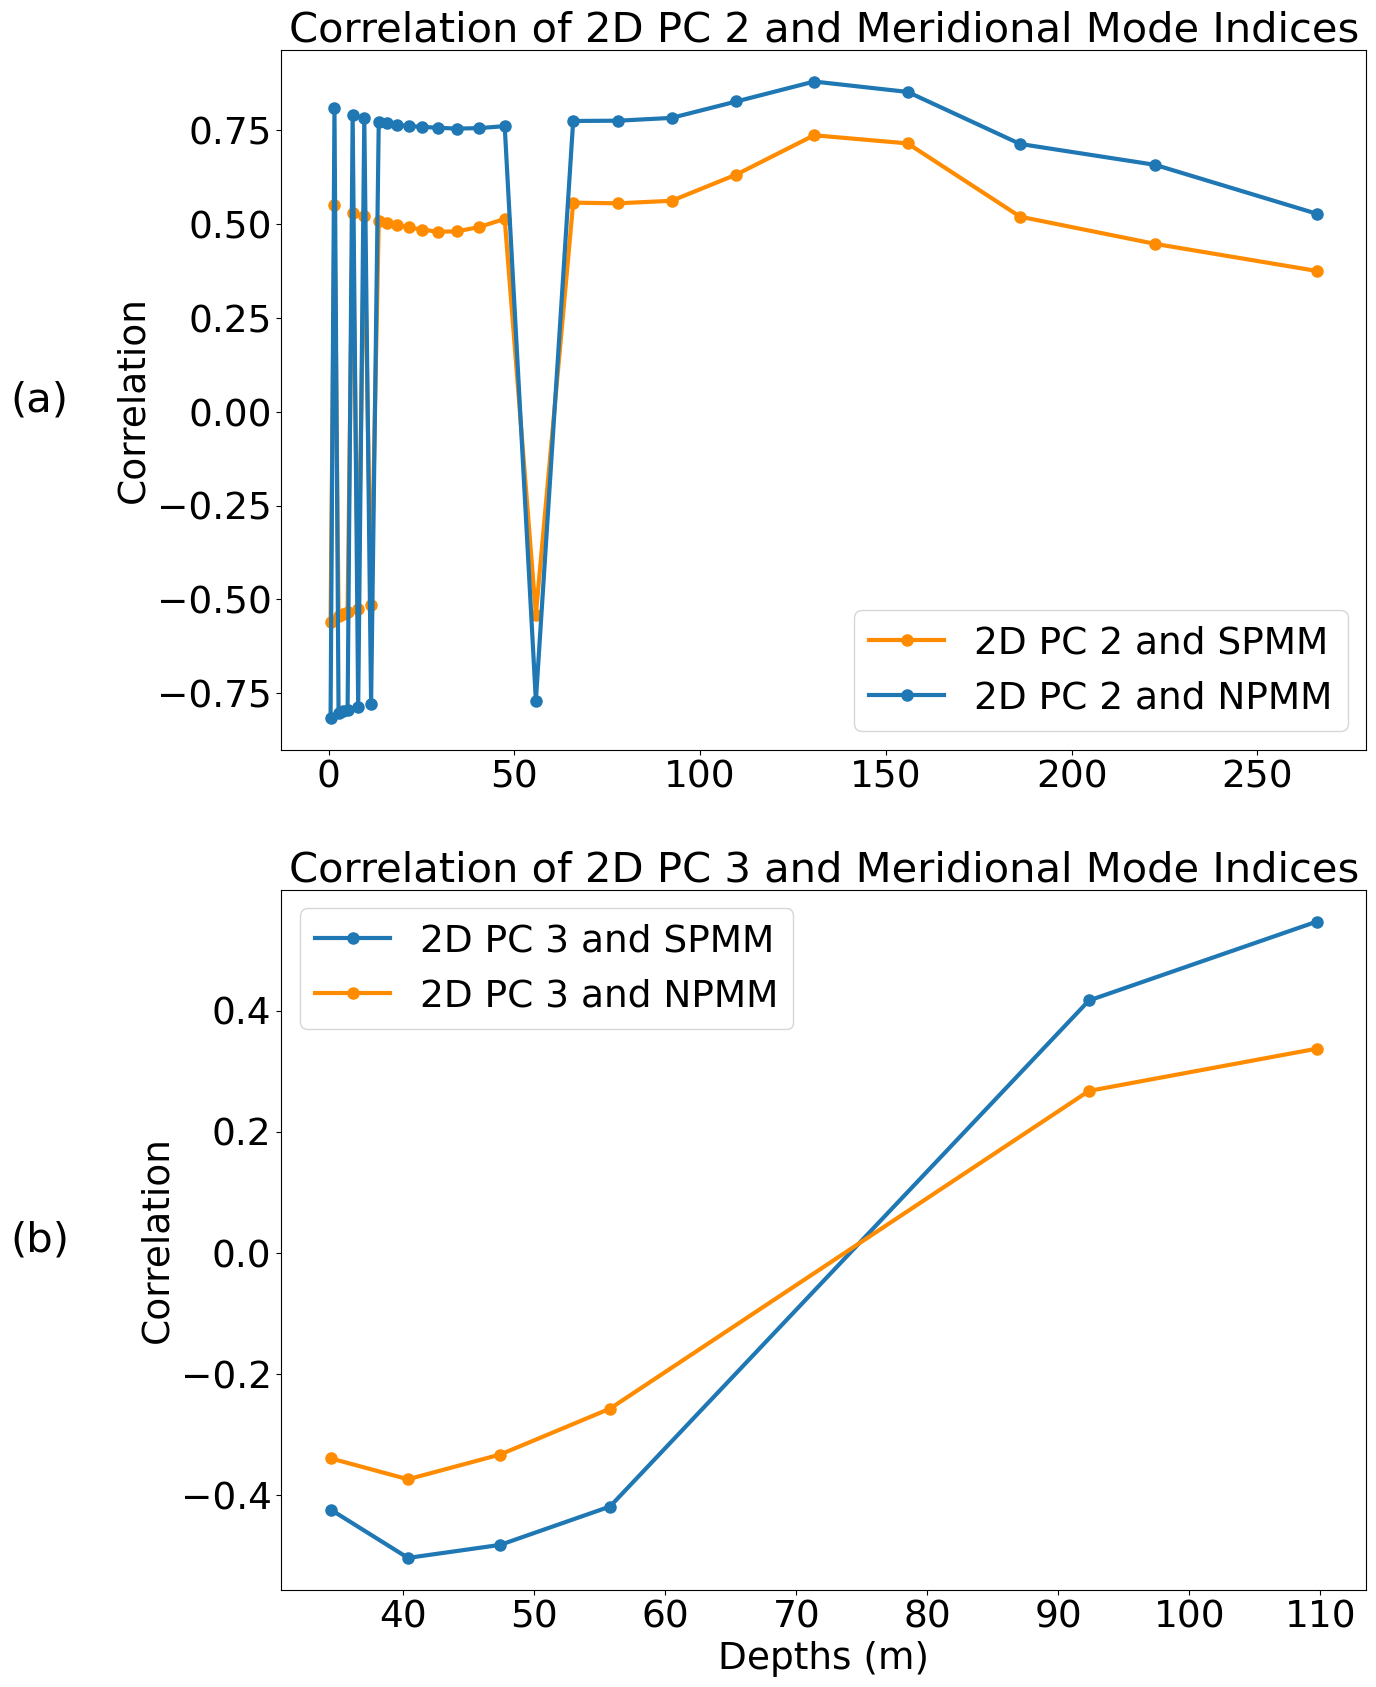

In [31]:
fig = plt.figure(figsize=(14, 20))
title_sz = 30
label_sz = title_sz-3
tick_sz = 5
line = 3

ax1 = plt.subplot(2, 1, 1)

plt.plot(depths[np.where(p_value1<.05)],correlation1[np.where(p_value1<.05)], color='darkorange', marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 2 and SPMM')
plt.plot(depths[np.where(p_value2<.05)],correlation2[np.where(p_value2<.05)], marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 2 and NPMM')
#plt.plot(depths[np.where(p_value3<.05)],correlation3[np.where(p_value3<.05)], marker = 'o', linewidth=line, markersize = line+5, label = 'PC2 and AMM')

plt.title('Correlation of 2D PC 2 and Meridional Mode Indices', fontsize = title_sz)

plt.ylabel('Correlation', fontsize = label_sz)
plt.legend(fontsize = label_sz)

plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)

ax1.text(-.25, 0.5, "(a)", transform=ax1.transAxes, va='center', fontsize = title_sz)


ax2 = plt.subplot(2, 1, 2)

ind = np.where(p_value11<.05)[0]
plt.plot(depths[ind],correlation11[ind],marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 3 and SPMM')
plt.plot(depths[np.where(p_value11<.05)],correlation33[np.where(p_value11<.05)], color='darkorange', marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 3 and NPMM')


#foo = correlation22[np.where(p_value22<.05)]
#foo_d = depths[np.where(p_value22<.05)]
#ind = np.argwhere(foo > 0)
#plt.plot(foo_d[ind[:-1,0]],foo[ind[:-1,0]], 'r', marker = 'o', dashes=[6, 2], 
#         linewidth=line, markersize = line+5, label = '2D PC 3 and EMI')

#plt.plot(depths[np.where(p_value3<.05)],correlation3[np.where(p_value3<.05)], marker = 'o', linewidth=line, markersize = line+5, label = 'PC2 and AMM')


plt.title('Correlation of 2D PC 3 and Meridional Mode Indices', fontsize = title_sz)
plt.xlabel('Depths (m)', fontsize = label_sz)
plt.ylabel('Correlation', fontsize = label_sz)
ax1.text(-.25, 0.5, "(b)", transform=ax2.transAxes, va='center', fontsize = title_sz)

plt.legend(fontsize = label_sz)

plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)


plt.savefig('D:/SCIL/Paper Figs/fig08.png', dpi=300, bbox_inches='tight')
plt.show()

In [147]:
correlation33[np.where(p_value11<.05)]

array([0.33957628, 0.37418361, 0.33330921, 0.25754202, 0.26734744,
       0.33712513])

## 2D vs 3D

In [37]:
from scipy.stats import pearsonr

mode = 2
p2_value1 = np.zeros(len(depths))
p2_value2 = np.zeros(len(depths))
p2_value3 = np.zeros(len(depths))

correlation2_1 = np.zeros(len(depths))
correlation2_2 = np.zeros(len(depths))
correlation2_3 = np.zeros(len(depths))

for depth_ind in range(len(depths)):
    correlation2_1[depth_ind], p2_value1[depth_ind] = pearsonr(-eigvecs3D[:,0], eigvecs[depth_ind,:,mode-1])
    correlation2_2[depth_ind], p2_value2[depth_ind] = pearsonr(-eigvecs3D[:,1], eigvecs[depth_ind,:,mode-1])
    correlation2_3[depth_ind], p2_value3[depth_ind] = pearsonr(-eigvecs3D[:,2], eigvecs[depth_ind,:,mode-1])


mode = 3
p3_value1 = np.zeros(len(depths))
p3_value2 = np.zeros(len(depths))
p3_value3 = np.zeros(len(depths))

correlation3_1 = np.zeros(len(depths))
correlation3_2 = np.zeros(len(depths))
correlation3_3 = np.zeros(len(depths))

for depth_ind in range(len(depths)):
    correlation3_1[depth_ind], p3_value1[depth_ind] = pearsonr(-eigvecs3D[:,0], -eigvecs[depth_ind,:,mode-1])
    correlation3_2[depth_ind], p3_value2[depth_ind] = pearsonr(-eigvecs3D[:,1], -eigvecs[depth_ind,:,mode-1])
    correlation3_3[depth_ind], p3_value3[depth_ind] = pearsonr(-eigvecs3D[:,2], -eigvecs[depth_ind,:,mode-1])

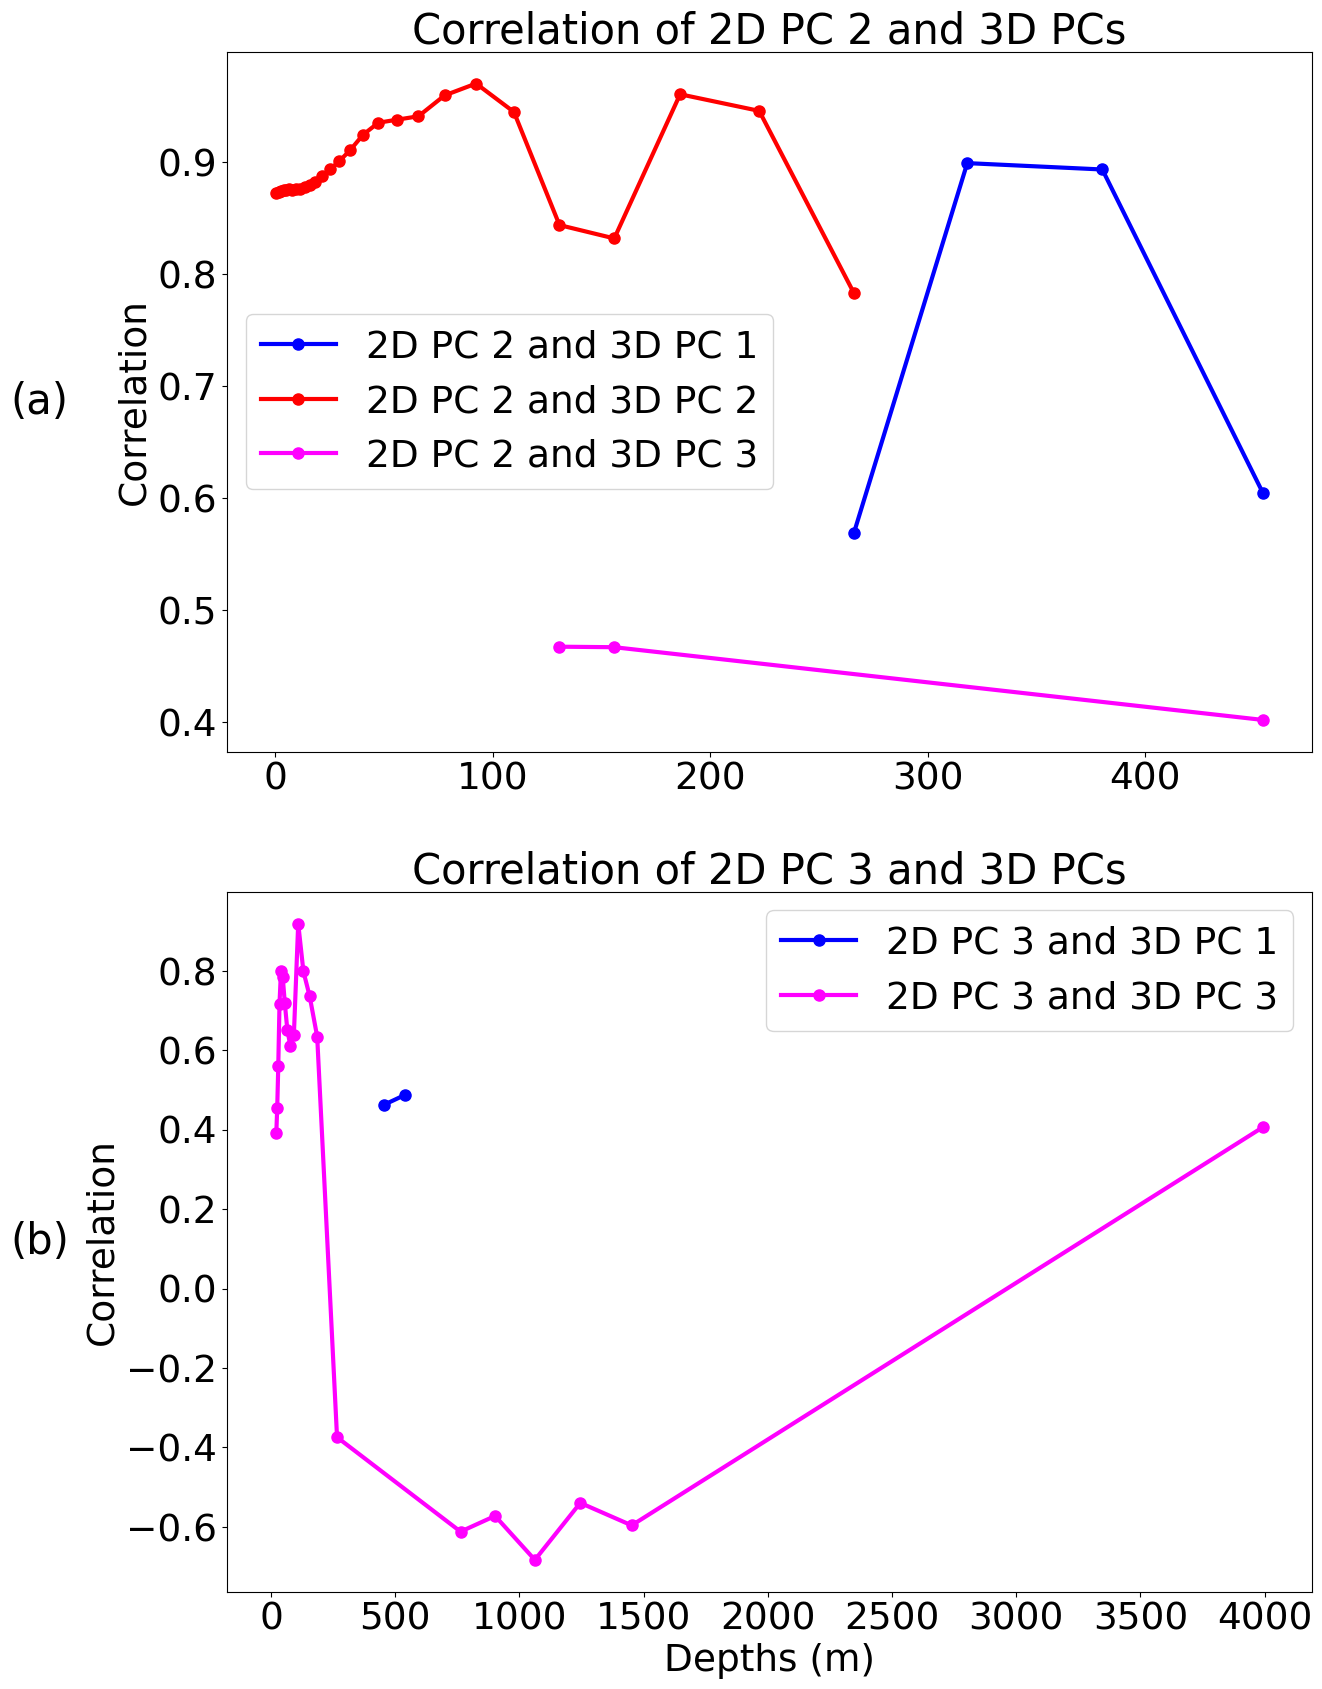

In [235]:
fig = plt.figure(figsize=(14, 20))
title_sz = 30
label_sz = title_sz-3
tick_sz = 5
line = 3

ax1 = plt.subplot(2, 1, 1)

plt.plot(depths[np.where(p2_value1<.05)],correlation2_1[np.where(p2_value1<.05)], color='b', marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 2 and 3D PC 1')

plt.plot(depths[np.where(p2_value2<.05)],correlation2_2[np.where(p2_value2<.05)],'r', marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 2 and 3D PC 2')
plt.plot(depths[np.where(p2_value3<.05)],correlation2_3[np.where(p2_value3<.05)], 'magenta', marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 2 and 3D PC 3')
#plt.plot(depths[np.where(p_value3<.05)],correlation3[np.where(p_value3<.05)], marker = 'o', linewidth=line, markersize = line+5, label = 'PC2 and AMM')

plt.title('Correlation of 2D PC 2 and 3D PCs', fontsize = title_sz)

plt.ylabel('Correlation', fontsize = label_sz)
plt.legend(fontsize = label_sz)

plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)

ax1.text(-.2, 0.5, "(a)", transform=ax1.transAxes, va='center', fontsize = title_sz)


ax2 = plt.subplot(2, 1, 2)
plt.plot(depths[np.where(p3_value1<.05)],correlation3_1[np.where(p3_value1<.05)], color='b', marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 3 and 3D PC 1')
#plt.plot(depths[np.where(p3_value2<.05)],correlation3_2[np.where(p3_value2<.05)], marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 3 and 3D PC 2')
plt.plot(depths[np.where(p3_value3<.05)],correlation3_3[np.where(p3_value3<.05)],'magenta', marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 3 and 3D PC 3')


plt.title('Correlation of 2D PC 3 and 3D PCs', fontsize = title_sz)
plt.xlabel('Depths (m)', fontsize = label_sz)
plt.ylabel('Correlation', fontsize = label_sz)
ax1.text(-.2, 0.5, "(b)", transform=ax2.transAxes, va='center', fontsize = title_sz)

plt.legend(fontsize = label_sz)

plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)

plt.savefig('E:/Paper Figs/PC compare.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
np.where(p3_value1<.05)

(array([30, 31], dtype=int64),)

In [159]:
correlation3_1[np.where(p3_value1<.05)]

array([0.4621806 , 0.48774443])

In [41]:
depths[np.where(p3_value3<.05)]

array([  21.59882,   25.21141,   29.44473,   34.43415,   40.34405,
         47.37369,   55.76429,   65.80727,   77.85385,   92.32607,
        109.7293 ,  130.666  ,  155.8507 ,  186.1256 ,  266.0403 ,
        763.3331 ,  902.3393 , 1062.44   , 1245.291  , 1452.251  ,
       3992.484  ], dtype=float32)

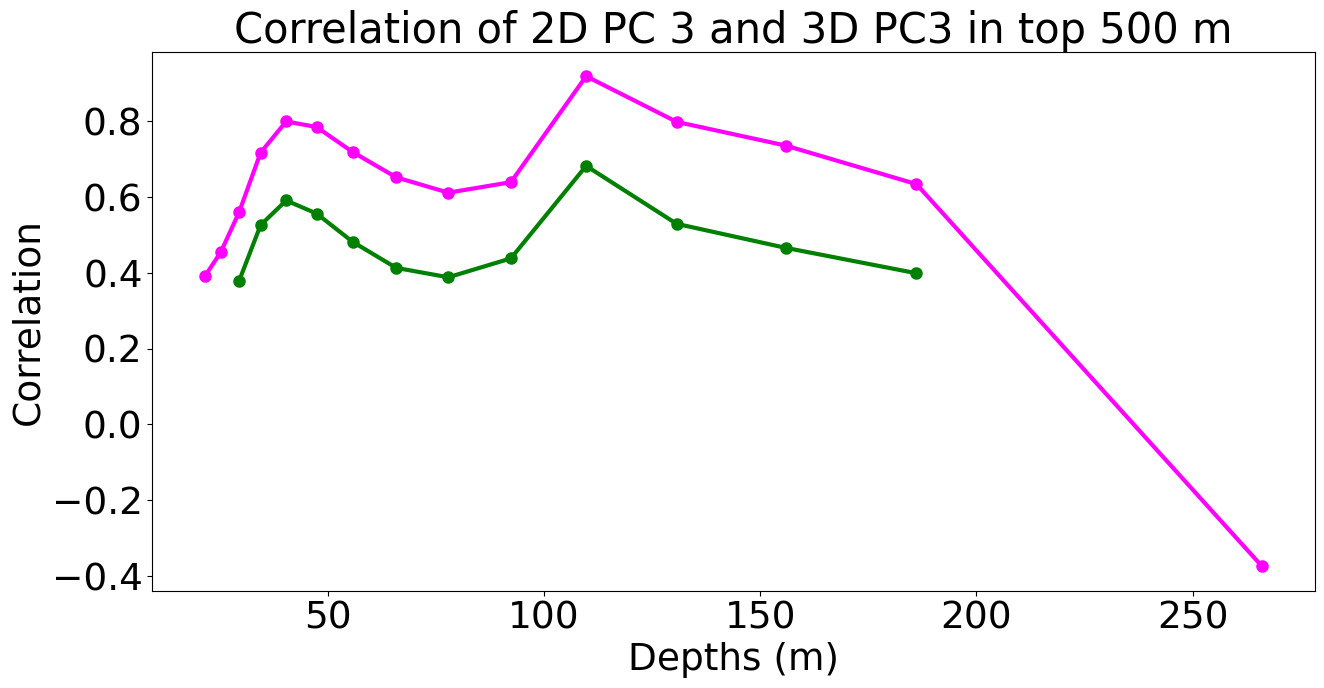

In [237]:
import matplotlib.patches as patches
fig = plt.figure(figsize=(15, 7))
title_sz = 30
label_sz = title_sz-3
tick_sz = 5
line = 3

ax2 = plt.subplot(1, 1, 1)
ind = np.where(p3_value3<.05)[0]
plt.plot(depths[ind[:15]],correlation3_3[ind[:15]],'magenta', marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 3 and 3D PC 3')
foo = correlation_TNI3[np.where(p_value_TNI3<.05)]
foo_d = depths[np.where(p_value_TNI3<.05)]
ind = np.where(foo_d<600)
plt.plot(foo_d[ind],-foo[ind], 'g', marker = 'o', 
         linewidth=line, markersize = line+5, label = '2D PC 3 and -TNI')

plt.title('Correlation of 2D PC 3 and 3D PC3 in top 500 m', fontsize = title_sz)
plt.xlabel('Depths (m)', fontsize = label_sz)
plt.ylabel('Correlation', fontsize = label_sz)
ax1.text(-.2, 0.5, "(b)", transform=ax2.transAxes, va='center', fontsize = title_sz)



plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)
#plt.savefig('E:/Paper Figs/PC compare 3 3.png', dpi=300, bbox_inches='tight')
plt.show()

In [167]:
correlation3_3[ind[:15]]

array([ 0.39172038,  0.45431018,  0.55940075,  0.71703237,  0.79949818,
        0.78474072,  0.71846113,  0.65191136,  0.61145253,  0.63912175,
        0.91879648,  0.79832369,  0.73587198,  0.63403541, -0.37445645])

In [243]:
depths[np.where(p3_value3<.05)]

array([  21.59882,   25.21141,   29.44473,   34.43415,   40.34405,
         47.37369,   55.76429,   65.80727,   77.85385,   92.32607,
        109.7293 ,  130.666  ,  155.8507 ,  186.1256 ,  266.0403 ,
        763.3331 ,  902.3393 , 1062.44   , 1245.291  , 1452.251  ,
       3992.484  ], dtype=float32)

In [265]:
print(depths[np.where(p2_value3<.05)])
print(correlation2_3[np.where(p2_value3<.05)])

[130.666  155.8507 453.9377]
[0.4673946  0.46694591 0.40206999]


In [263]:
print(depths[np.where(p3_value3<.05)])
print(correlation3_3[np.where(p3_value3<.05)])

[  21.59882   25.21141   29.44473   34.43415   40.34405   47.37369
   55.76429   65.80727   77.85385   92.32607  109.7293   130.666
  155.8507   186.1256   266.0403   763.3331   902.3393  1062.44
 1245.291   1452.251   3992.484  ]
[ 0.39172038  0.45431018  0.55940075  0.71703237  0.79949818  0.78474072
  0.71846113  0.65191136  0.61145253  0.63912175  0.91879648  0.79832369
  0.73587198  0.63403541 -0.37445645 -0.61213143 -0.57260709 -0.6832653
 -0.53974518 -0.59633129  0.40576016]


In [241]:
print(np.where(p2_value2<.05))
print(depths[np.where(p2_value2<.05)])
print(correlation2_2[np.where(p2_value2<.05)])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=int64),)
[  0.494025   1.541375   2.645669   3.819495   5.078224   6.440614
   7.92956    9.572997  11.405     13.46714   15.81007   18.49556
  21.59882   25.21141   29.44473   34.43415   40.34405   47.37369
  55.76429   65.80727   77.85385   92.32607  109.7293   130.666
 155.8507   186.1256   222.4752   266.0403  ]
[0.87182866 0.87288899 0.87382901 0.87451482 0.87511419 0.8756905
 0.87538271 0.87573323 0.87622113 0.87739422 0.87942812 0.88246049
 0.88708402 0.8933944  0.90072351 0.91043901 0.92421103 0.93496631
 0.9376263  0.94072645 0.9593604  0.96994902 0.94455918 0.84364209
 0.8317341  0.96037393 0.94555285 0.78290567]


In [245]:
np.max(correlation2_2[np.where(p2_value2<.05)])

0.9699490167143803

In [237]:
print(depths[np.where(p3_value3<.05)])
print(correlation3_3[np.where(p3_value3<.05)])

[  21.59882   25.21141   29.44473   34.43415   40.34405   47.37369
   55.76429   65.80727   77.85385   92.32607  109.7293   130.666
  155.8507   186.1256   266.0403   763.3331   902.3393  1062.44
 1245.291   1452.251   3992.484  ]
[ 0.39172038  0.45431018  0.55940075  0.71703237  0.79949818  0.78474072
  0.71846113  0.65191136  0.61145253  0.63912175  0.91879648  0.79832369
  0.73587198  0.63403541 -0.37445645 -0.61213143 -0.57260709 -0.6832653
 -0.53974518 -0.59633129  0.40576016]


In [401]:
depths[np.where(p3_value1<.05)]

array([453.9377, 541.0889], dtype=float32)

In [255]:
print(depths[np.where(p2_value1<.05)])
print(correlation2_1[np.where(p2_value1<.05)])

[266.0403 318.1274 380.213  453.9377]
[0.56901631 0.89893522 0.89324752 0.60500067]


## TNI

In [35]:
p_value_TNI2 = np.zeros(len(depths))
correlation_TNI2 = np.zeros(len(depths))
p_value_TNI3 = np.zeros(len(depths))
correlation_TNI3 = np.zeros(len(depths))

for depth_ind in range(len(depths)):
    correlation_TNI2[depth_ind], p_value_TNI2[depth_ind] = pearsonr(TNI_GLORYS, eigvecs[depth_ind,:,1])
    correlation_TNI3[depth_ind], p_value_TNI3[depth_ind] = pearsonr(TNI_GLORYS, -eigvecs[depth_ind,:,2])

In [115]:
correlation_TNI3[np.where(p_value_TNI3<.05)]

array([-0.37820656, -0.52582922, -0.59090518, -0.55640436, -0.48141262,
       -0.4129208 , -0.38818174, -0.43802908, -0.68213506, -0.52920669,
       -0.46594632, -0.3988493 ,  0.44059288,  0.42818735,  0.39124379,
        0.38754283])

In [117]:
depths[np.where(p_value_TNI3<.05)]

array([  29.44473,   34.43415,   40.34405,   47.37369,   55.76429,
         65.80727,   77.85385,   92.32607,  109.7293 ,  130.666  ,
        155.8507 ,  186.1256 ,  763.3331 , 1062.44   , 1452.251  ,
       3220.82   ], dtype=float32)

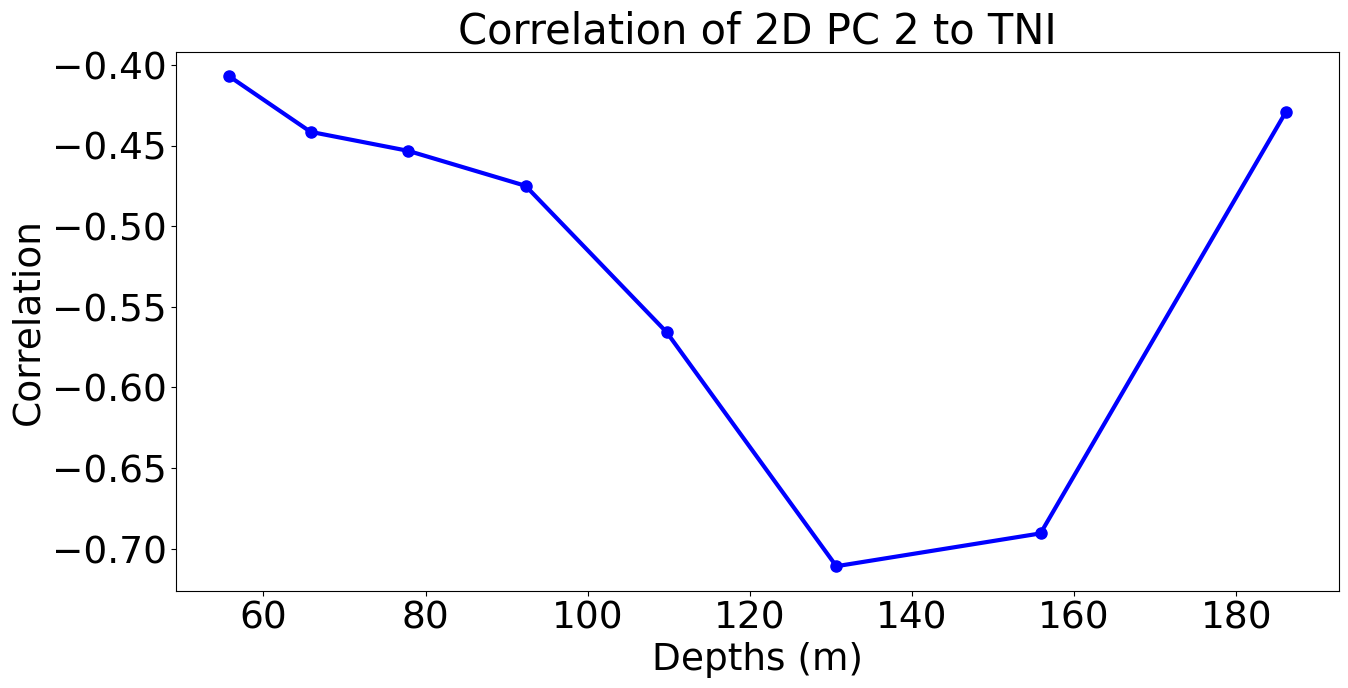

In [279]:
import matplotlib.patches as patches
fig = plt.figure(figsize=(15, 7))
title_sz = 30
label_sz = title_sz-3
tick_sz = 5
line = 3
'''
ax1 = plt.subplot(1, 1, 1)
plt.title('Correlation of 2D PC 2 to TNI', fontsize = title_sz)
plt.plot(depths[np.where(p_value_TNI2<.05)],correlation_TNI2[np.where(p_value_TNI2<.05)], 'b', marker = 'o', linewidth=line, markersize = line+5, label = 'PC2 and TNI')
plt.ylabel('Correlation', fontsize = label_sz)

# Create a Rectangle patch
rect = patches.Rectangle((0,-0.2), 300, -0.7, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect)


plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)
ax1.text(-.2, 0.5, "(a)", transform=ax1.transAxes, va='center', fontsize = label_sz)
'''

ax2 = plt.subplot(1, 1, 1)
plt.title('Correlation of 2D PC 2 to TNI', fontsize = title_sz)

foo = correlation_TNI2[np.where(p_value_TNI2<.05)]
foo_d = depths[np.where(p_value_TNI2<.05)]
ind = np.where(foo_d<600)
plt.plot(foo_d[ind],foo[ind], 'b', marker = 'o', 
         linewidth=line, markersize = line+5, label = 'PC2 and TNI')

  
plt.xlabel('Depths (m)', fontsize = label_sz)
plt.ylabel('Correlation', fontsize = label_sz)
  

plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)
#ax1.text(-.22, 0.5, "(b)", transform=ax2.transAxes, va='center', fontsize = label_sz)

plt.savefig('E:/Paper Figs/fig11.png', dpi=300, bbox_inches='tight')


In [283]:
print(depths[np.where(p_value_TNI2<.05)])
print(correlation_TNI2[np.where(p_value_TNI2<.05)])

[ 55.76429  65.80727  77.85385  92.32607 109.7293  130.666   155.8507
 186.1256 ]
[-0.40703024 -0.44150506 -0.45329042 -0.4749701  -0.56569837 -0.71079785
 -0.6904503  -0.42911643]


In [133]:
np.where(p_value11<.05)

(array([15, 16, 17, 18, 21, 22], dtype=int64),)

In [123]:
depths[np.where(p_value11<.05)]

array([ 34.43415,  40.34405,  47.37369,  55.76429,  92.32607, 109.7293 ],
      dtype=float32)

In [127]:
correlation11[np.where(p_value11<.05)]

array([0.424168  , 0.50402907, 0.4825467 , 0.41919079, 0.4166897 ,
       0.54708016])

In [129]:
foo_d[ind[:-1,0]]

array([ 34.43415,  40.34405,  47.37369,  55.76429,  65.80727,  77.85385,
        92.32607, 109.7293 , 130.666  ], dtype=float32)

In [131]:
foo[ind[:-1,0]]

array([0.42017724, 0.49246638, 0.48867143, 0.45281597, 0.42093525,
       0.41223234, 0.4428694 , 0.56845107, 0.40262438])

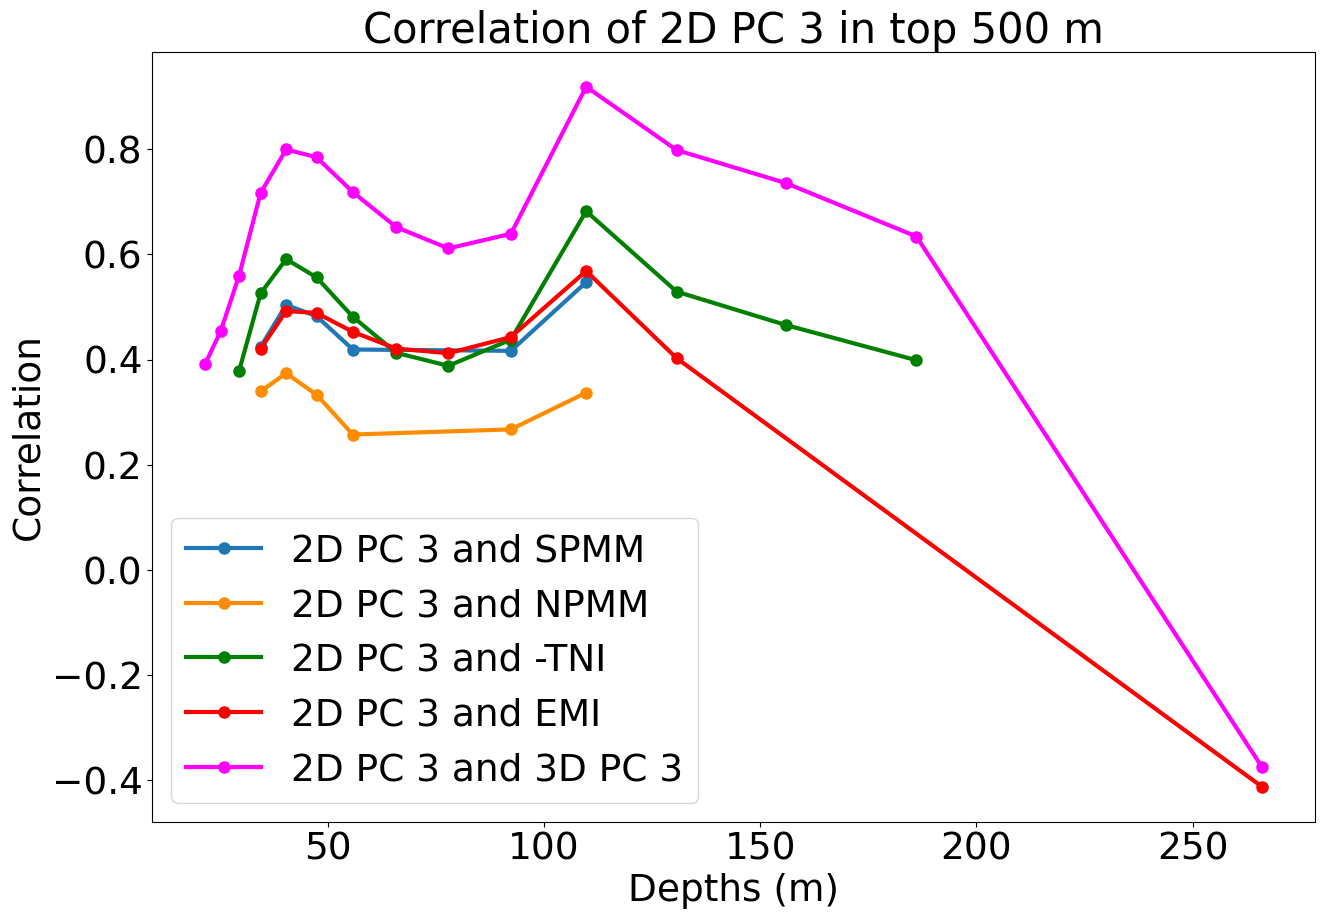

In [157]:
#dashes=[6, 2], 
fig = plt.figure(figsize=(15, 10))
title_sz = 30
label_sz = title_sz-3
tick_sz = 5
line = 3

plt.plot(depths[np.where(p_value11<.05)],correlation11[np.where(p_value11<.05)], marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 3 and SPMM')
#foo = correlation22[np.where(p_value22<.05)]
#foo_d = depths[np.where(p_value22<.05)]
#ind = np.argwhere(foo > 0)
#plt.plot(foo_d[ind[:-1,0]],foo[ind[:-1,0]], 'r', marker = 'o', 
#         linewidth=line, markersize = line+5, label = '2D PC 3 and EMI')
plt.plot(depths[np.where(p_value11<.05)],correlation33[np.where(p_value11<.05)], color='darkorange', marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 3 and NPMM')


foo = correlation_TNI3[np.where(p_value_TNI3<.05)]
foo_d = depths[np.where(p_value_TNI3<.05)]
ind = np.where(foo_d<600)
plt.plot(foo_d[ind],-foo[ind], 'g', marker = 'o', 
         linewidth=line, markersize = line+5, label = '2D PC 3 and -TNI')


ind = np.where(p_value22<.05)[0]
plt.plot(depths[ind[:10]],correlation22[ind[:10]], 'r', marker = 'o',
         linewidth=line, markersize = line+5, label = '2D PC 3 and EMI')
plt.legend(fontsize = label_sz)

ind = np.where(p3_value3<.05)[0]
plt.plot(depths[ind[:15]],correlation3_3[ind[:15]],color = 'magenta', marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 3 and 3D PC 3')


plt.title('Correlation of 2D PC 3 in top 500 m', fontsize = title_sz)
plt.xlabel('Depths (m)', fontsize = label_sz)
plt.ylabel('Correlation', fontsize = label_sz)


plt.legend(fontsize = label_sz)

plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)


plt.savefig('E:/Paper Figs/SNPMM EMI TNI.png', dpi=300, bbox_inches='tight')

plt.show()

In [315]:
depths[np.where(p_value22<.05)[0]]

array([  34.43415,   40.34405,   47.37369,   55.76429,   65.80727,
         77.85385,   92.32607,  109.7293 ,  130.666  ,  266.0403 ,
        541.0889 ,  763.3331 ,  902.3393 , 1062.44   , 1452.251  ,
       3220.82   ], dtype=float32)

In [123]:
correlation_TNI3[np.where(p_value_TNI3<.05)]

array([-0.37820656, -0.52582922, -0.59090518, -0.55640436, -0.48141262,
       -0.4129208 , -0.38818174, -0.43802908, -0.68213506, -0.52920669,
       -0.46594632, -0.3988493 ,  0.44059288,  0.42818735,  0.39124379,
        0.38754283])

In [125]:
depths[np.where(p_value_TNI3<.05)]

array([  29.44473,   34.43415,   40.34405,   47.37369,   55.76429,
         65.80727,   77.85385,   92.32607,  109.7293 ,  130.666  ,
        155.8507 ,  186.1256 ,  763.3331 , 1062.44   , 1452.251  ,
       3220.82   ], dtype=float32)

Text(-0.2, 0.5, '(b)')

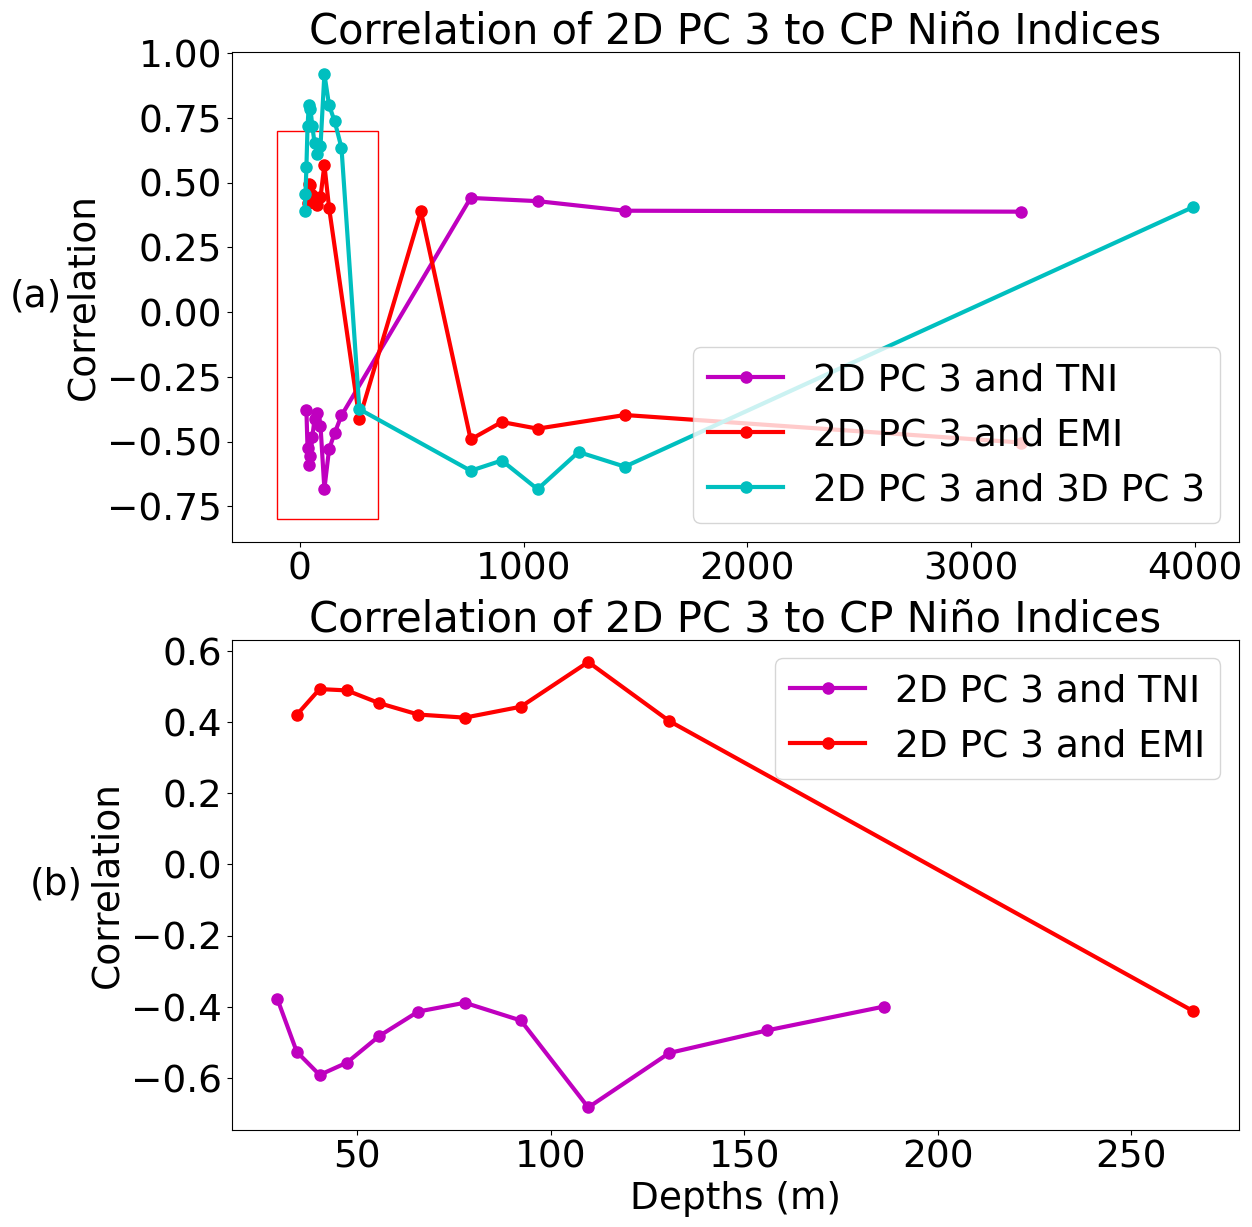

In [475]:
import matplotlib.patches as patches
fig = plt.figure(figsize=(13, 14))

ax1 = plt.subplot(2, 1, 1)
plt.title('Correlation of 2D PC 3 to CP Niño Indices', fontsize = title_sz)
plt.plot(depths[np.where(p_value_TNI3<.05)],correlation_TNI3[np.where(p_value_TNI3<.05)], 'm', marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 3 and TNI')
plt.plot(depths[np.where(p_value22<.05)],correlation22[np.where(p_value22<.05)], 'r', marker = 'o',  
         linewidth=line, markersize = line+5, label = '2D PC 3 and EMI')
plt.ylabel('Correlation', fontsize = label_sz)
ind = np.where(p3_value3<.05)[0]
plt.plot(depths[ind[:]],correlation3_3[ind[:]],'c', marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 3 and 3D PC 3')


# Create a Rectangle patch
rect = patches.Rectangle((-100,-.8), 450, 1.5, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect)

plt.legend(fontsize = label_sz)

plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)
ax1.text(-.22, 0.5, "(a)", transform=ax1.transAxes, va='center', fontsize = label_sz)


ax2 = plt.subplot(2, 1, 2)
plt.title('Correlation of 2D PC 3 to CP Niño Indices', fontsize = title_sz)

foo = correlation_TNI3[np.where(p_value_TNI3<.05)]
foo_d = depths[np.where(p_value_TNI3<.05)]
ind = np.where(foo_d<600)
plt.plot(foo_d[ind],foo[ind], 'm', marker = 'o', 
         linewidth=line, markersize = line+5, label = '2D PC 3 and TNI')



ind = np.where(p_value22<.05)[0]
plt.plot(depths[ind[:10]],correlation22[ind[:10]], 'r', marker = 'o',
         linewidth=line, markersize = line+5, label = '2D PC 3 and EMI')
plt.legend(fontsize = label_sz)

plt.xlabel('Depths (m)', fontsize = label_sz)
plt.ylabel('Correlation', fontsize = label_sz)
  

plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)
ax1.text(-.2, 0.5, "(b)", transform=ax2.transAxes, va='center', fontsize = label_sz)

#plt.savefig('E:/Paper Figs/fig13.png', dpi=300, bbox_inches='tight')


In [327]:
depths[ind[:10]]

array([ 34.43415,  40.34405,  47.37369,  55.76429,  65.80727,  77.85385,
        92.32607, 109.7293 , 130.666  , 266.0403 ], dtype=float32)

In [343]:
correlation22[ind[:10]]

array([ 0.42017724,  0.49246638,  0.48867143,  0.45281597,  0.42093525,
        0.41223234,  0.4428694 ,  0.56845107,  0.40262438, -0.41200589])

In [307]:
depths[np.where(p_value22<.05)]

array([  34.43415,   40.34405,   47.37369,   55.76429,   65.80727,
         77.85385,   92.32607,  109.7293 ,  130.666  ,  266.0403 ,
        541.0889 ,  763.3331 ,  902.3393 , 1062.44   , 1452.251  ,
       3220.82   ], dtype=float32)

In [287]:
depths[np.where(p_value_TNI3<.05)]

array([  29.44473,   34.43415,   40.34405,   47.37369,   55.76429,
         65.80727,   77.85385,   92.32607,  109.7293 ,  130.666  ,
        155.8507 ,  186.1256 ,  763.3331 , 1062.44   , 1452.251  ,
       3220.82   ], dtype=float32)

In [285]:
correlation_TNI3[np.where(p_value_TNI3<.05)]

array([-0.37820656, -0.52582922, -0.59090518, -0.55640436, -0.48141262,
       -0.4129208 , -0.38818174, -0.43802908, -0.68213506, -0.52920669,
       -0.46594632, -0.3988493 ,  0.44059288,  0.42818735,  0.39124379,
        0.38754283])

(array([0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56]),
 [Text(0, 0.4, '0.40'),
  Text(0, 0.42000000000000004, '0.42'),
  Text(0, 0.44, '0.44'),
  Text(0, 0.46, '0.46'),
  Text(0, 0.48000000000000004, '0.48'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.52, '0.52'),
  Text(0, 0.54, '0.54'),
  Text(0, 0.56, '0.56')])

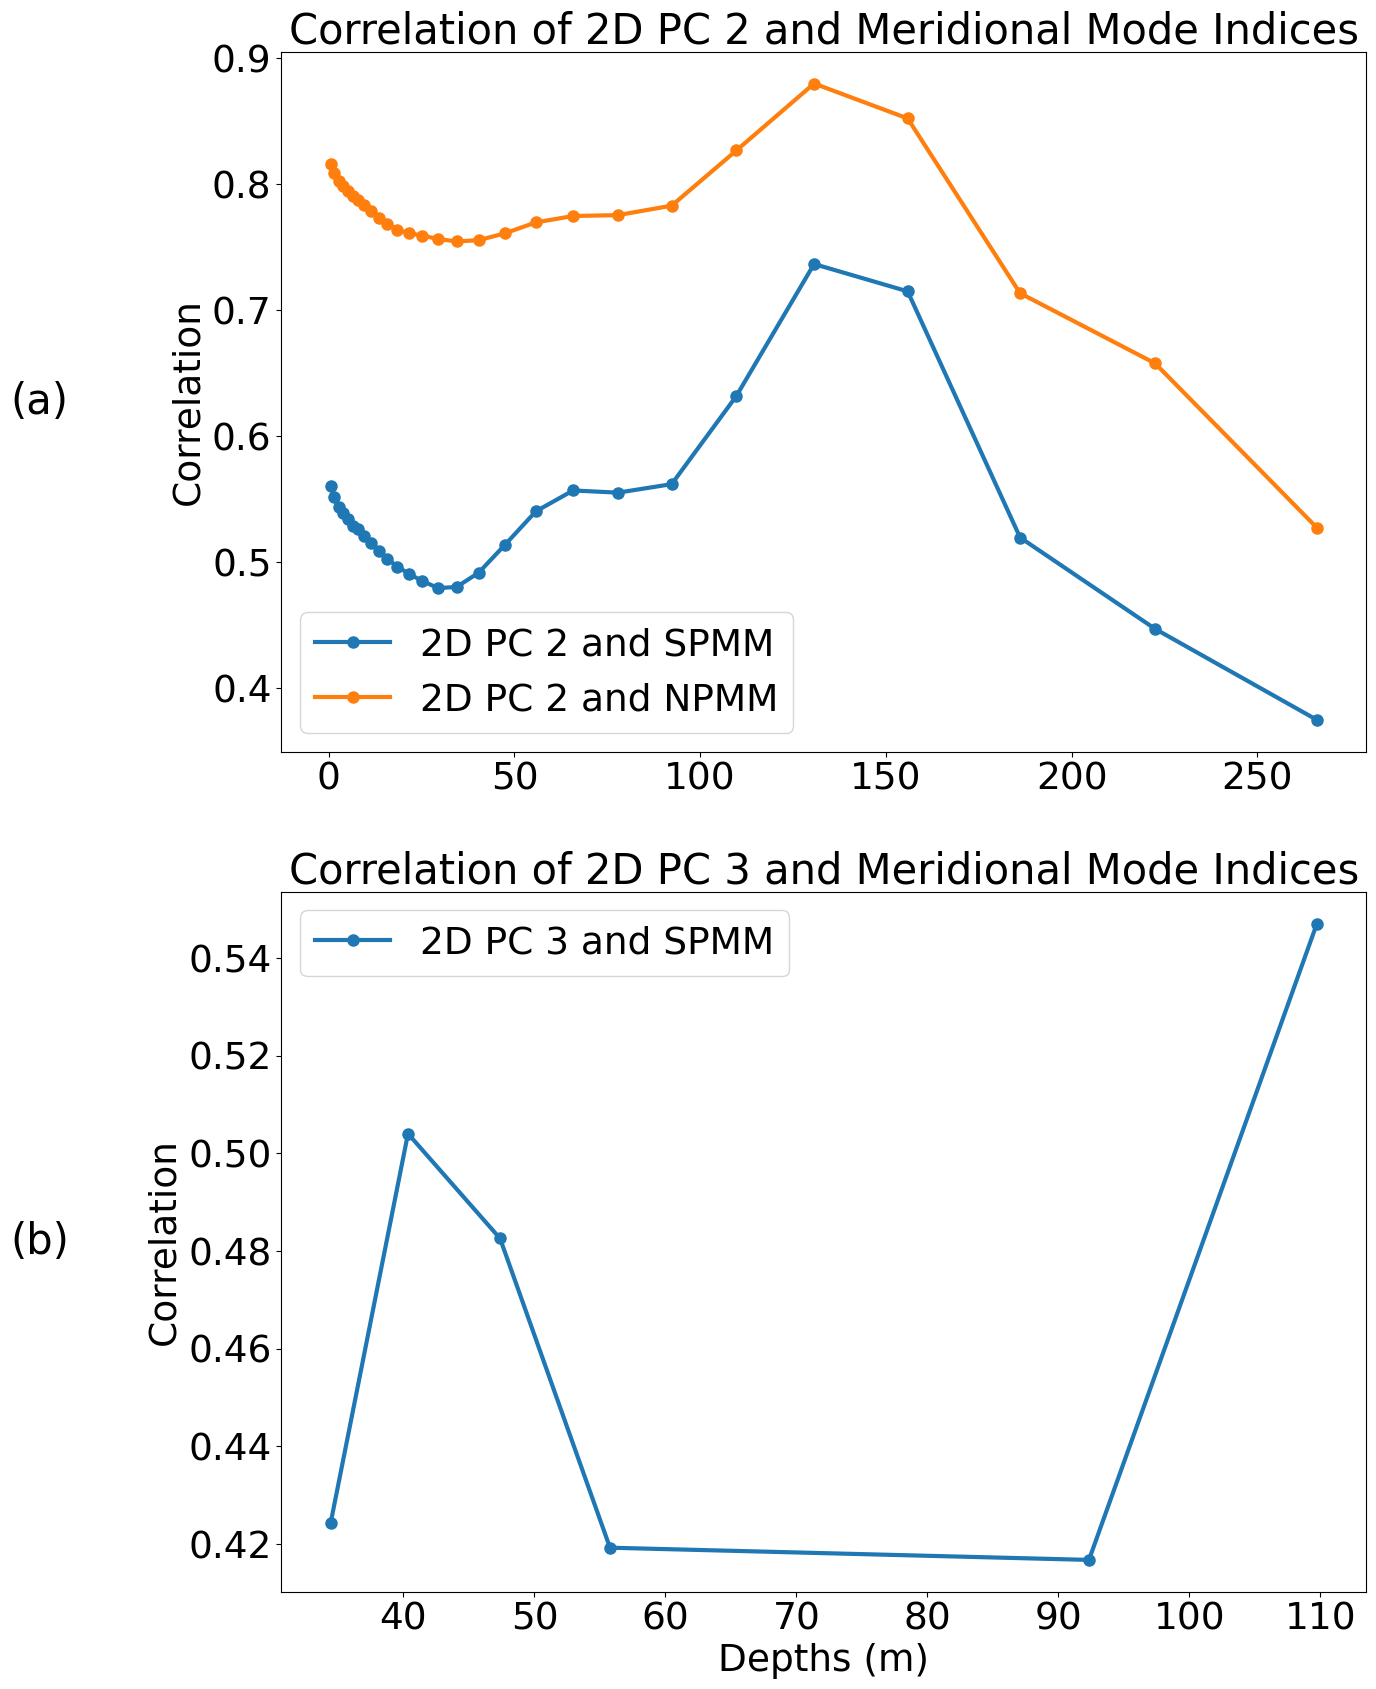

In [90]:
fig = plt.figure(figsize=(14, 20))
title_sz = 30
label_sz = title_sz-3
tick_sz = 5
line = 3

ax1 = plt.subplot(2, 1, 1)

plt.plot(depths[np.where(p_value1<.05)],correlation1[np.where(p_value1<.05)], marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 2 and SPMM')
plt.plot(depths[np.where(p_value2<.05)],correlation2[np.where(p_value2<.05)], marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 2 and NPMM')
#plt.plot(depths[np.where(p_value3<.05)],correlation3[np.where(p_value3<.05)], marker = 'o', linewidth=line, markersize = line+5, label = 'PC2 and AMM')

plt.title('Correlation of 2D PC 2 and Meridional Mode Indices', fontsize = title_sz)

plt.ylabel('Correlation', fontsize = label_sz)
plt.legend(fontsize = label_sz)

plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)

ax1.text(-.25, 0.5, "(a)", transform=ax1.transAxes, va='center', fontsize = title_sz)


ax2 = plt.subplot(2, 1, 2)

plt.plot(depths[np.where(p_value11<.05)],correlation11[np.where(p_value11<.05)], marker = 'o', linewidth=line, markersize = line+5, label = '2D PC 3 and SPMM')
#foo = correlation22[np.where(p_value22<.05)]
#foo_d = depths[np.where(p_value22<.05)]
#ind = np.argwhere(foo > 0)
#plt.plot(foo_d[ind[:-1,0]],foo[ind[:-1,0]], 'r', marker = 'o', dashes=[6, 2], 
#         linewidth=line, markersize = line+5, label = '2D PC 3 and EMI')

#plt.plot(depths[np.where(p_value3<.05)],correlation3[np.where(p_value3<.05)], marker = 'o', linewidth=line, markersize = line+5, label = 'PC2 and AMM')


plt.title('Correlation of 2D PC 3 and Meridional Mode Indices', fontsize = title_sz)
plt.xlabel('Depths (m)', fontsize = label_sz)
plt.ylabel('Correlation', fontsize = label_sz)
ax1.text(-.25, 0.5, "(b)", transform=ax2.transAxes, va='center', fontsize = title_sz)

plt.legend(fontsize = label_sz)

plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)

In [90]:
ind = np.where(p_value_TNI3<.05)

In [108]:
#Nino 1+2
lat_cut_start = 840#120
lat_cut_end = 961#240
lon_cut_start = 3240#1800
lon_cut_end = 3361#1920
NINO12= np.zeros((len(ind[0])))
for k,depth in enumerate(ind[0]):
    anom = EOF3[depth, lat_cut_start:lat_cut_end, lon_cut_start:lon_cut_end]
    NINO12[k] = np.nanmean(anom)
# Nino 4
lat_cut_start = 900#180
lat_cut_end = 1021#300
lon_cut_start = 1920#480
lon_cut_end = 2521#1080
NINO4 = np.zeros((len(ind[0])))
for k,depth in enumerate(ind[0]):
    anom = EOF3[depth,lat_cut_start:lat_cut_end, lon_cut_start:lon_cut_end]
    NINO4[k] = np.nanmean(anom)

In [164]:
#################################################################################################################
#################################################################################################################
# Function will read in eigenvalues and eigenvectors saved in CSV file based on the EOF_directory
# Input: None
# Output:
#         - eigvals: a 1D float array with all eigenvectors corresponding eigenvalues
#         - eigvecs: a 2D float array with all eigenvectors in the columns of the matrix

# Important Variables:
#         - month: defined previously by the Set_Global_Variables function
#         - EOf_directory: defined by the set_EOF_Anom_directory function
def read_evec_3D(prefix):
    # Read the CSV file
    EOF_directory           = os.path.join(data_directory, 'cut_EOFs/Entire Ocean')
    fn     = prefix +'_eigenvalues_eigenvectors.csv'
    fn     = os.path.join(EOF_directory, fn)
    df = pd.read_csv(fn)

    # Extract the eigenvalues
    eigvals = df['Eigenvalue'].values

    # Extract the eigenvectors
    eigvecs = df.drop(columns=['Eigenvalue']).values.T
    return eigvals,eigvecs

In [166]:
_,eigvecs3D = read_evec_3D('Winter Avg')

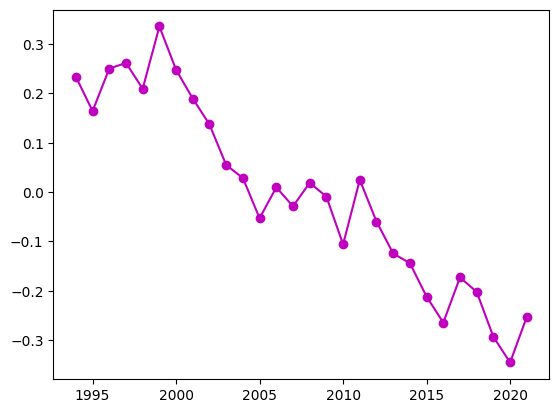

In [168]:
plt.plot(years, eigvecs3D[:,1], marker = 'o', c = 'm', label = '3D PC2')

In [154]:
fig = plt.figure(figsize=(10, 6))
title_sz = 19
label_sz = title_sz-3
tick_sz = 5
line = 3
def f(depth_ind):
    depth = depths[depth_ind]
    plt.plot(years, TNI_GLORYS, marker = 'o',c = 'b', label = 'TNI')
    plt.plot(years, -eigvecs3D[:,1], marker = 'o', c = 'm', label = '3D PC2')
    plt.plot(years, -eigvecs3D[:,2], marker = 'o', c = 'r', label = '3D PC3')
    plt.plot(years, eigvecs[depth_ind,:,2], marker = 'o',c = 'g', label = '2D PC3')

    if depth_ind == 0:
        plt.title(f'2D PC2 at Surface', fontsize = title_sz)
    else: 
        plt.title(f'2D PC2 at {np.round(depth.astype(int), 0)} m', fontsize = title_sz)
    
    plt.legend(fontsize = label_sz)
    plt.xticks(fontsize = label_sz)
    plt.yticks(fontsize = label_sz)
    plt.grid(True)
interactive(f, depth_ind = (0, len(depths)-1))

<Figure size 1000x600 with 0 Axes>

interactive(children=(IntSlider(value=24, description='depth_ind', max=49), Output()), _dom_classes=('widget-i…

In [351]:
title_sz = 19
label_sz = title_sz-3
mode = 3
def f(depth_ind):
    depth = depths[depth_ind]

    dat = EOF3[depth_ind,:,:]
    #clip = np.nanmax(abs(dat)) # set min and max values
    clip = .0002 # set min and max values
    dat = np.maximum(np.minimum(dat, clip), -clip) # climp min and max values

    #Plot first depth
    fig, ax = plt.subplots(figsize=(18., 11.)) 
    #plt.figure(figsize=(15., 6.))

    mymap = Basemap(projection='cyl',llcrnrlat=cut_lat[0],urcrnrlat=cut_lat[-1],llcrnrlon=cut_lon[0],urcrnrlon=cut_lon[-1],resolution='c')
    mymap.drawcoastlines(color='black', linewidth=.5)
    mymap.drawmapboundary()
    mymap.drawparallels(np.arange(cut_lat[0],cut_lat[-1],20), labels = [1,0,0,0], fontsize = label_sz)
    mymap.drawmeridians(np.arange(cut_lon[0],cut_lon[-1],60), labels = [0,0,0,1], fontsize = label_sz)

    norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
    ax.contourf(cut_lon, cut_lat,  dat, 20, cmap = newcmp2, norm= norm)

    if depth_ind == 0:
        plt.title(f"{month} EOF {mode} at Surface", size = title_sz)
    else:    
        plt.title(f"{month} EOF {mode} at {round(depth)}m", size = title_sz)
    
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
    sm.set_array([]) 
    #cbar = plt.colorbar(sm, ax = ax, format = mpl.ticker.ScalarFormatter(useMathText=True), shrink = .97)
    cbar = plt.colorbar(sm, ax = ax, format = mpl.ticker.ScalarFormatter(useMathText=True), shrink = .5)
    cbar.ax.yaxis.get_offset_text().set_fontsize(15) # change exp size
    cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
    cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left 
    cbar.ax.tick_params(labelsize=15)    # set label size of ticks
    cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
    cbar.update_ticks()
interactive(f, depth_ind = (0,len(depths)-1))

interactive(children=(IntSlider(value=24, description='depth_ind', max=49), Output()), _dom_classes=('widget-i…

# 3D Plot

In [43]:
EOF_directory           = os.path.join(data_directory, 'cut_EOFs/Entire Ocean')

EOF2_3D = read_EOFs(2, EOF_directory)
EOF3_3D = read_EOFs(3,EOF_directory)

EOF2_3D = -EOF2_3D
EOF3_3D = -EOF3_3D

In [319]:
depths[37]

1452.251

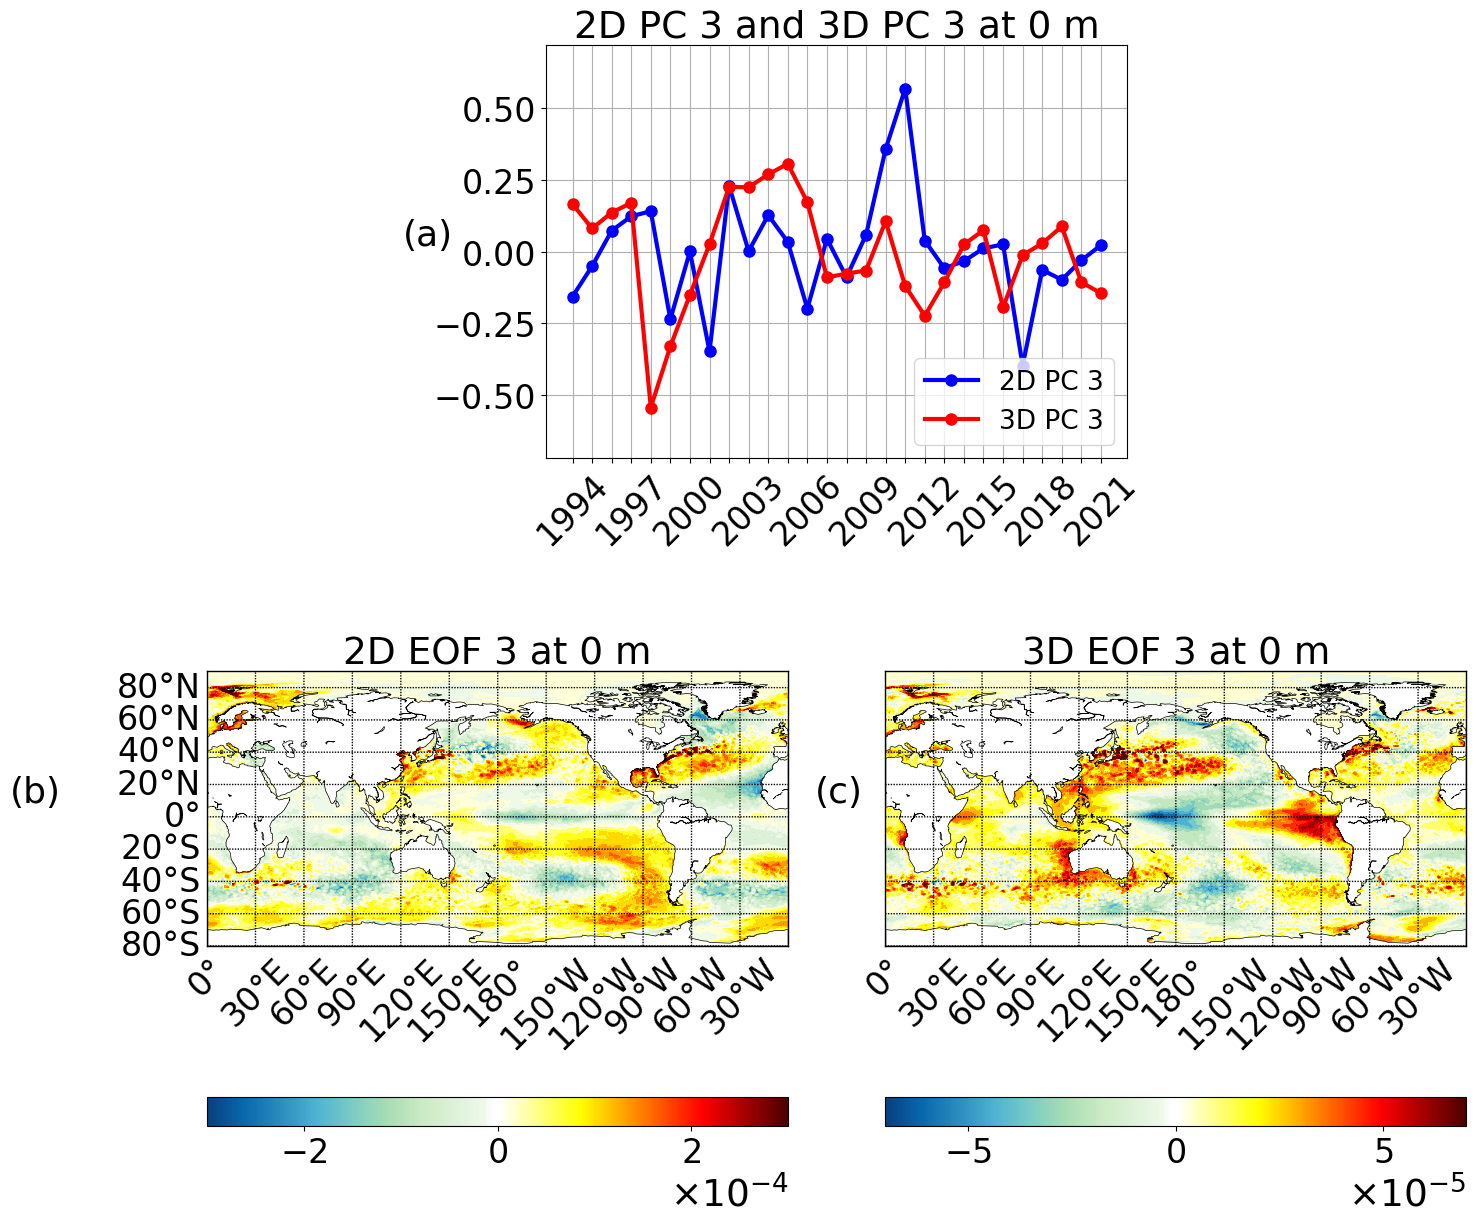

In [333]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
title_sz = 27
label_sz = title_sz - 3
tick_sz = 5
fig = plt.figure(figsize=(25, 15))
gs = gridspec.GridSpec(2, 6, figure=fig, hspace=0.1, wspace=0.4, height_ratios=[.6,1])

# Top row - 1 plot (centered, spans 2 columns)
ax1 = fig.add_subplot(gs[0, 2:4])
plt.ylabel('(a)', rotation='horizontal', size=title_sz-1)

mode = 3
depth_ind = 0

plt.plot(years, eigvecs[depth_ind, :,mode-1],'b', marker = 'o',label = '2D PC 3', linewidth=line, markersize = line+5)
plt.plot(years, -eigvecs3D[:,mode-1],'r', marker = 'o',label = '3D PC 3', linewidth=line, markersize = line+5)
plt.title(f"2D PC {mode} and 3D PC {mode} at {round(depths[depth_ind])} m", fontsize=title_sz)

plt.xticks(years)
plt.xticks(rotation=45)
plt.xticks(fontsize = label_sz)
plt.ylim([-.72,.72])
plt.yticks(fontsize = label_sz)
plt.legend(fontsize = label_sz-5, loc = 'lower right')

ax1.set_xticklabels([])
ax1.tick_params(axis='y', labelsize=label_sz)  # You can set any size you want

plt.grid(True)

# Get the current ticks
xticks = ax1.get_xticks()

# Set labels for every other tick, leave others blank
xtick_labels = [str(int(tick)) if i % 3 == 0 else '' for i, tick in enumerate(xticks)]
ax1.set_xticklabels(xtick_labels)
ax1.tick_params(axis='x', labelsize=label_sz)  # You can set any size you want

# Middle row - 2 plots
ax2 = fig.add_subplot(gs[1, 1:3])
clip = .0003
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz, rotation = 45)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax2.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
plt.ylabel('(b)', rotation='horizontal', size=title_sz-1, labelpad = 120)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])
cbar = plt.colorbar(sm, ax = ax2, orientation='horizontal', format = mpl.ticker.ScalarFormatter(useMathText=True), pad=0.22)
cbar.ax.xaxis.get_offset_text().set_fontsize(title_sz)
cbar.ax.yaxis.OFFSETTEXTPAD = title_sz
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()




ax3 = fig.add_subplot(gs[1, 3:5])
clip = .00007
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)

dat = -EOF3_3D[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz, rotation = 45)


ax3.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"3D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
plt.ylabel('(c)', rotation='horizontal', size=title_sz-1, labelpad = 30)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])
cbar = plt.colorbar(sm, ax = ax3, orientation='horizontal', format = mpl.ticker.ScalarFormatter(useMathText=True), pad=0.22)
cbar.ax.xaxis.get_offset_text().set_fontsize(title_sz)
cbar.ax.yaxis.OFFSETTEXTPAD = title_sz
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
#plt.savefig('E:/Paper Figs/Compare at 1452.png', dpi=300, bbox_inches='tight')
plt.show()

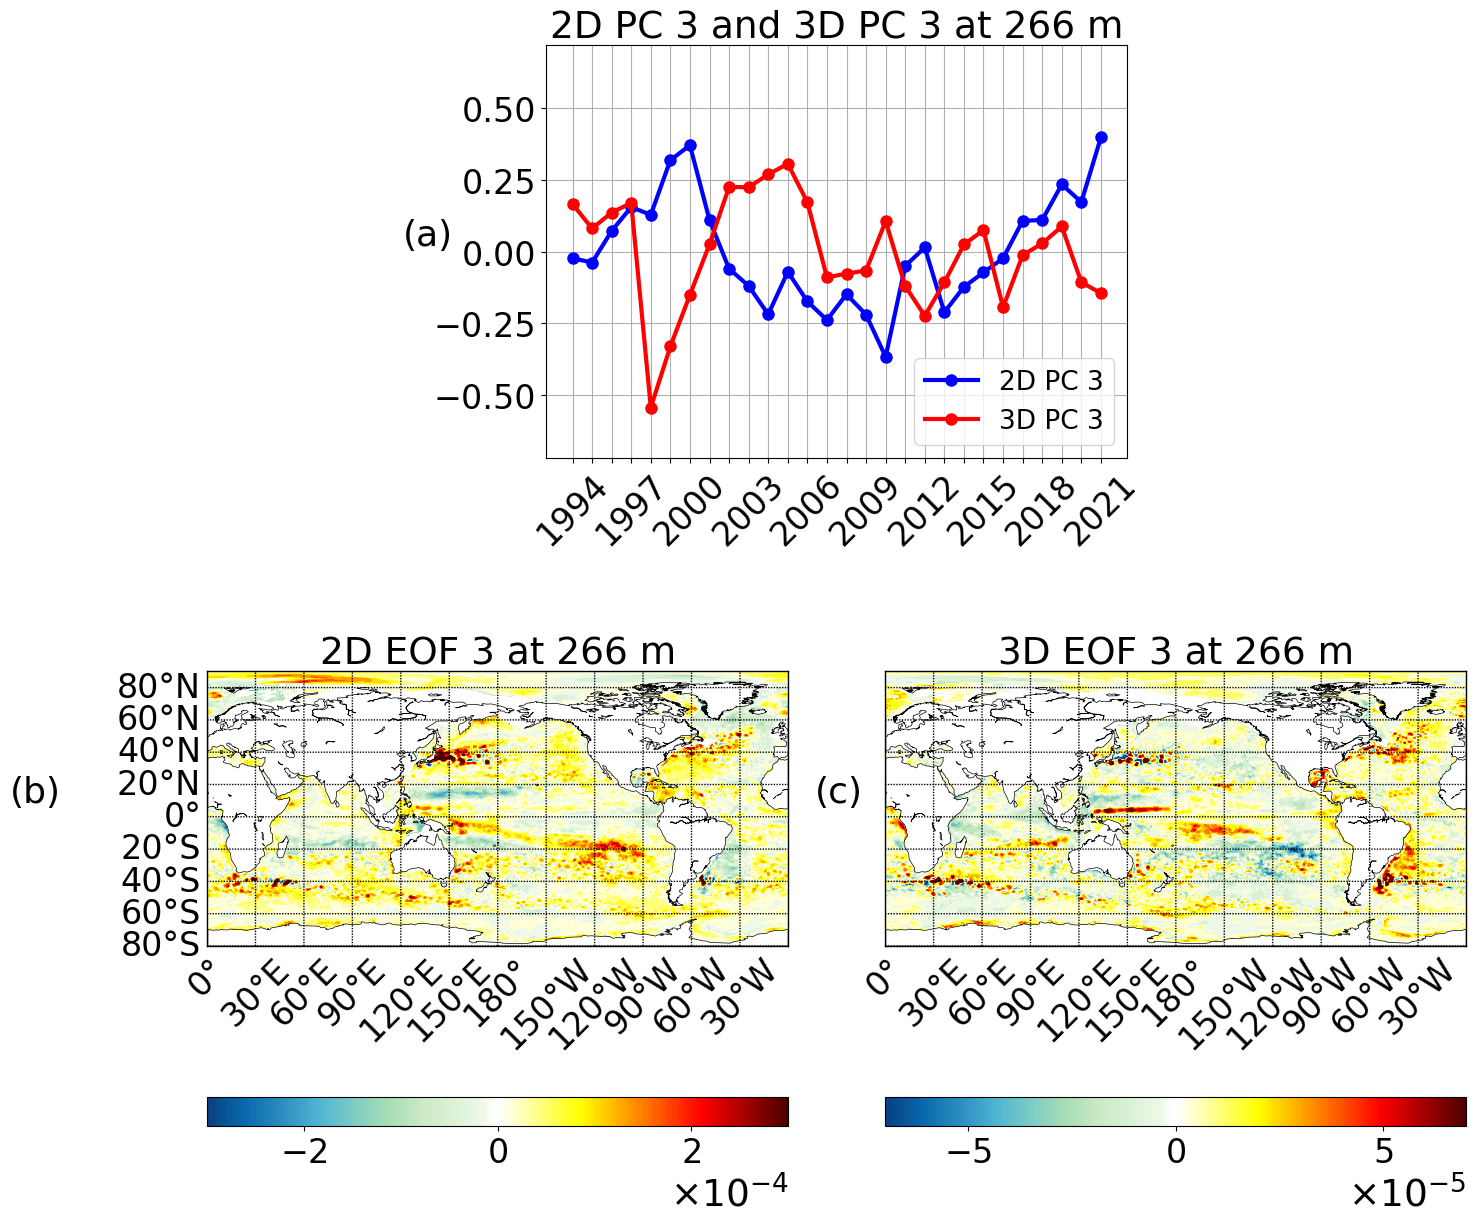

In [335]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
title_sz = 27
label_sz = title_sz - 3
tick_sz = 5
fig = plt.figure(figsize=(25, 15))
gs = gridspec.GridSpec(2, 6, figure=fig, hspace=0.1, wspace=0.4, height_ratios=[.6,1])

# Top row - 1 plot (centered, spans 2 columns)
ax1 = fig.add_subplot(gs[0, 2:4])
plt.ylabel('(a)', rotation='horizontal', size=title_sz-1)

mode = 3
depth_ind = 27

plt.plot(years, -eigvecs[depth_ind, :,mode-1],'b', marker = 'o',label = '2D PC 3', linewidth=line, markersize = line+5)
plt.plot(years, -eigvecs3D[:,mode-1],'r', marker = 'o',label = '3D PC 3', linewidth=line, markersize = line+5)
plt.title(f"2D PC {mode} and 3D PC {mode} at {round(depths[depth_ind])} m", fontsize=title_sz)

plt.xticks(years)
plt.xticks(rotation=45)
plt.xticks(fontsize = label_sz)
plt.ylim([-.72,.72])
plt.yticks(fontsize = label_sz)
plt.legend(fontsize = label_sz-5, loc = 'lower right')

ax1.set_xticklabels([])
ax1.tick_params(axis='y', labelsize=label_sz)  # You can set any size you want

plt.grid(True)

# Get the current ticks
xticks = ax1.get_xticks()

# Set labels for every other tick, leave others blank
xtick_labels = [str(int(tick)) if i % 3 == 0 else '' for i, tick in enumerate(xticks)]
ax1.set_xticklabels(xtick_labels)
ax1.tick_params(axis='x', labelsize=label_sz)  # You can set any size you want

# Middle row - 2 plots
ax2 = fig.add_subplot(gs[1, 1:3])
clip = .0003
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz, rotation = 45)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax2.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
plt.ylabel('(b)', rotation='horizontal', size=title_sz-1, labelpad = 120)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])
cbar = plt.colorbar(sm, ax = ax2, orientation='horizontal', format = mpl.ticker.ScalarFormatter(useMathText=True), pad=0.22)
cbar.ax.xaxis.get_offset_text().set_fontsize(title_sz)
cbar.ax.yaxis.OFFSETTEXTPAD = title_sz
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()




ax3 = fig.add_subplot(gs[1, 3:5])
clip = .00007
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)

dat = EOF3_3D[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz, rotation = 45)


ax3.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"3D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
plt.ylabel('(c)', rotation='horizontal', size=title_sz-1, labelpad = 30)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])
cbar = plt.colorbar(sm, ax = ax3, orientation='horizontal', format = mpl.ticker.ScalarFormatter(useMathText=True), pad=0.22)
cbar.ax.xaxis.get_offset_text().set_fontsize(title_sz)
cbar.ax.yaxis.OFFSETTEXTPAD = title_sz
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
#plt.savefig('E:/Paper Figs/PC EOF compare.png', dpi=300, bbox_inches='tight')
plt.show()

In [311]:
depths[22]

109.7293

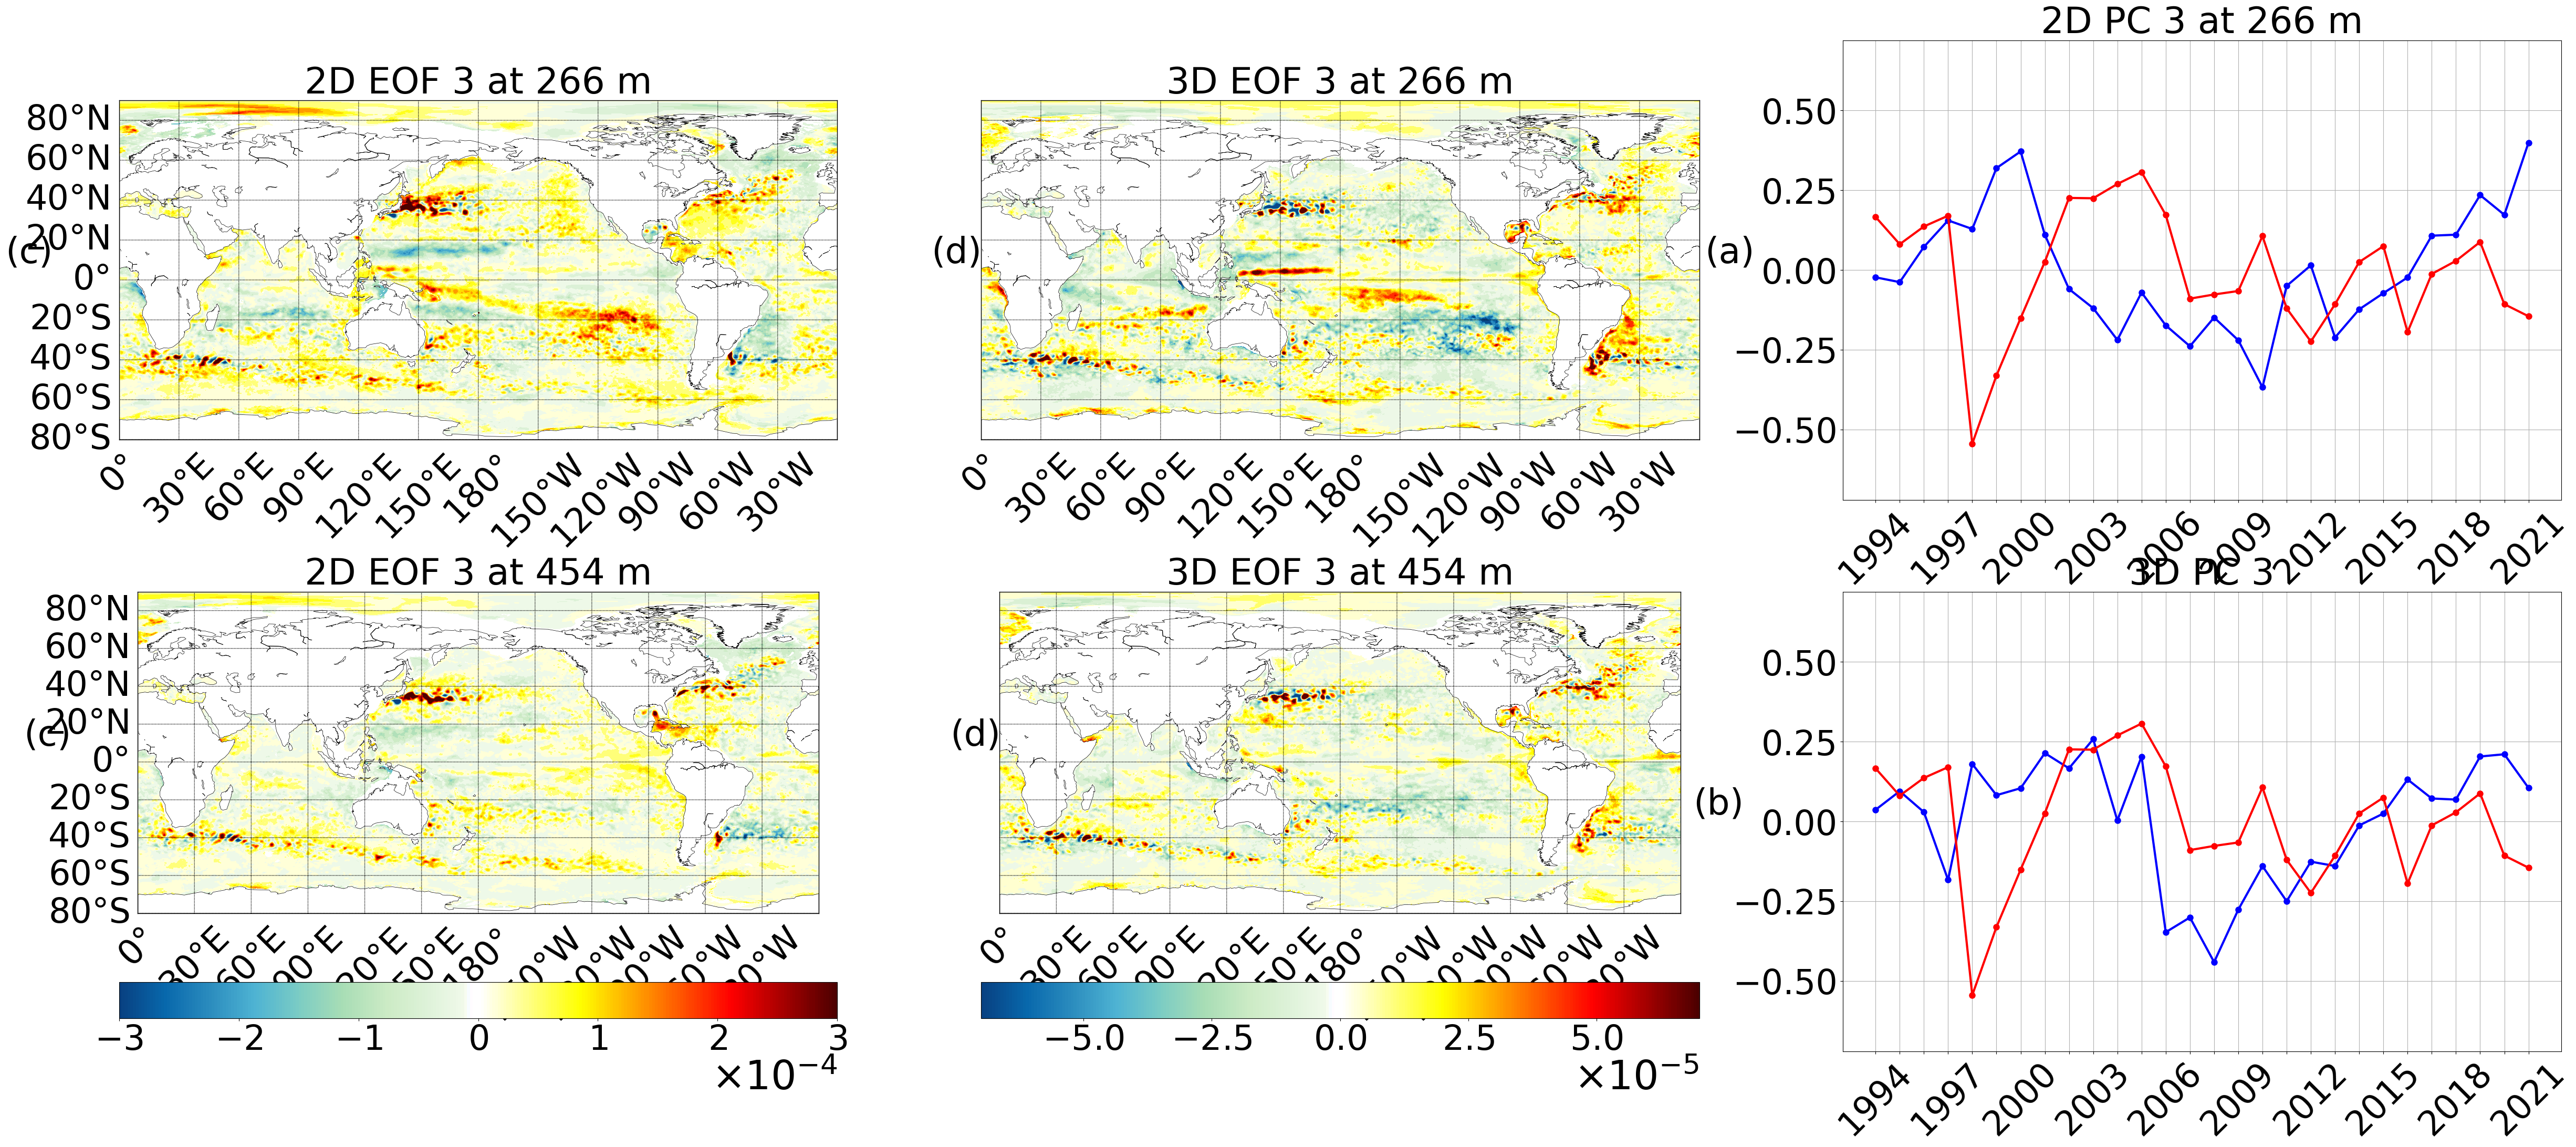

In [97]:
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#fig = plt.figure(figsize=(19, 36.))
fig = plt.figure(figsize=(28, 32))

title_sz = 35
label_sz = title_sz - 4
tick_sz = 5

clip = .0003


###################################################################
# Fourth subplot
ax = fig.add_subplot(8,3,1)
plt.ylabel('(a)', rotation='horizontal', size=title_sz-1, labelpad = 120)
depth_ind = 0
dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at Surface", size=title_sz)

###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,4)
plt.ylabel('(d)', rotation='horizontal', size=title_sz-1, labelpad = 120)
depth_ind = 2

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,7)
plt.ylabel('(g)', rotation='horizontal', size=title_sz-1, labelpad = 120)
depth_ind = 3

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,10)
plt.ylabel('(j)', rotation='horizontal', size=title_sz-1, labelpad = 120)
depth_ind = 4

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,13)
plt.ylabel('(m)', rotation='horizontal', size=title_sz-1, labelpad = 120)
depth_ind = 5

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,16)
plt.ylabel('(p)', rotation='horizontal', size=title_sz-1, labelpad = 120)
depth_ind = 6

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz, rotation = 45)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
###################################################################
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,2)
plt.ylabel('(b)', rotation='horizontal', size=title_sz-1, labelpad = 30)
depth_ind = 7
dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)

###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,5)
plt.ylabel('(e)', rotation='horizontal', size=title_sz-1, labelpad = 30)
depth_ind = 8

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,8)
plt.ylabel('(h)', rotation='horizontal', size=title_sz-1, labelpad = 30)
depth_ind = 9

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,11)
plt.ylabel('(k)', rotation='horizontal', size=title_sz-1, labelpad = 30)
depth_ind = 10

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,14)
plt.ylabel('(n)', rotation='horizontal', size=title_sz-1, labelpad = 30)
depth_ind = 11

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz, rotation = 45)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)

###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,17)
plt.ylabel('(q)', rotation='horizontal', size=title_sz-1, labelpad = 30)
depth_ind = 12

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz, rotation = 45)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
###################################################################
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,3)
plt.ylabel('(c)', rotation='horizontal', size=title_sz-1, labelpad = 30)
depth_ind = 13
dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)

###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,6)
plt.ylabel('(f)', rotation='horizontal', size=title_sz-1, labelpad = 30)
depth_ind = 14

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,9)
plt.ylabel('(i)', rotation='horizontal', size=title_sz-1, labelpad = 30)
depth_ind = 15

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,12)
plt.ylabel('(l)', rotation='horizontal', size=title_sz-1, labelpad = 30)
depth_ind = 16

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,15)
plt.ylabel('(o)', rotation='horizontal', size=title_sz-1, labelpad = 30)
depth_ind = 17

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz, rotation = 45)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
# Fourth subplot
ax = fig.add_subplot(6,3,18)
plt.ylabel('(r)', rotation='horizontal', size=title_sz-1, labelpad = 30)
depth_ind = 18

dat = EOF3[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)

mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz, rotation = 45)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)

plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)

#################################################################################################################
#################################################################################################################

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
cax = fig.add_axes([0.12, 0.03, 0.78, 0.02]) #(left, bottom, width, height)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])
cbar = plt.colorbar(sm, cax = cax, orientation='horizontal', format = mpl.ticker.ScalarFormatter(useMathText=True))
cbar.ax.xaxis.get_offset_text().set_fontsize(title_sz+5)
cbar.ax.yaxis.OFFSETTEXTPAD = title_sz
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
plt.savefig('E:/Paper Figs/fig14.png', dpi=300, bbox_inches='tight')

plt.show()

In [295]:
#################################################################################################################
#################################################################################################################
# Function converts longitude from 0 to 360 to centered at 180. This is just for naming purposes.
# it does not shift the axis of the data
# Input:
#         - lon_0_360: float with the longitude value from 0 to 360
# Output:
#         - convert: String with the longitude value on a 180 centered scale

# Important Variables:
#         - lon_180_w_180_e: float with the longitude value on a 180 centered scale
def convert_longitude(lon_0_360):
    lon_180_w_180_e = lon_0_360 - 360 if lon_0_360 > 180 else lon_0_360
    if lon_180_w_180_e < 0:
        lon_180_w_180_e = abs(lon_180_w_180_e)
        convert = f"{lon_180_w_180_e}$^\circ$W"
    elif lon_180_w_180_e == 180:
        convert = f"{lon_180_w_180_e}$^\circ$"
    else:
        convert = f"{lon_180_w_180_e}$^\circ$E"
    return convert
#################################################################################################################
#################################################################################################################

# Function formats longitude to get rid of degree symbols
# Input:
#         - longitude: numeric corresponding to parallel

def format_longitude(longitude):
    if not 0 <= longitude <= 360:
        return "Invalid longitude. Must be between 0 and 360 degrees."

    if longitude == 0:
        hemisphere = ''
        degrees = longitude
    elif longitude < 180:
        hemisphere = 'E'
        degrees = longitude
    elif longitude == 180:
        hemisphere = ''
        degrees = longitude
    else:
        hemisphere = 'W'
        degrees = 360 - longitude

    return f"{degrees:.0f}{hemisphere}"

#################################################################################################################
#################################################################################################################

# Function formats latitude to get rid of degree symbols
# Input:
#         - latitude: numeric corresponding to meridian


def format_latitude(latitude):
    if not -90 <= latitude <= 90:
        return "Invalid latitude. Must be between -90 and 90 degrees."

    if latitude > 0:
        hemisphere = "N"
    elif latitude == 0:
        hemisphere = ""
    else:
        hemisphere = 'S'

    degrees = abs(latitude)

    return f"{degrees:.0f}{hemisphere}"

In [86]:
lat_cut_start = 0
lat_cut_end = -1
lon_cut_start =0
lon_cut_end = -1
depth_cut_end = 30

lon_ticks   = np.arange(lon[lon_cut_start], lon[lon_cut_end]+1, 30)
lat_ticks   = np.arange(lat[lat_cut_start], lat[lat_cut_end]+1, 20)
depth_ticks = np.arange(0, depths[depth_cut_end], 50)



# create grid to plot in x and z for the y cross section
xx,yy = np.meshgrid(lon, lat)
# plotting land
mask = np.isnan(EOF2[0, :,:]) # create a mask for the NaN values
masked_array = np.where(mask, EOF2[0, :,:], np.nan)          # change points with values to NaN
end_of_map = np.nanmin(EOF2[31,:,:]) # minimum value to define bottom of map
masked_array = np.where(~mask, masked_array, end_of_map) # change NaN points to values

In [249]:
depths[21]

92.32607

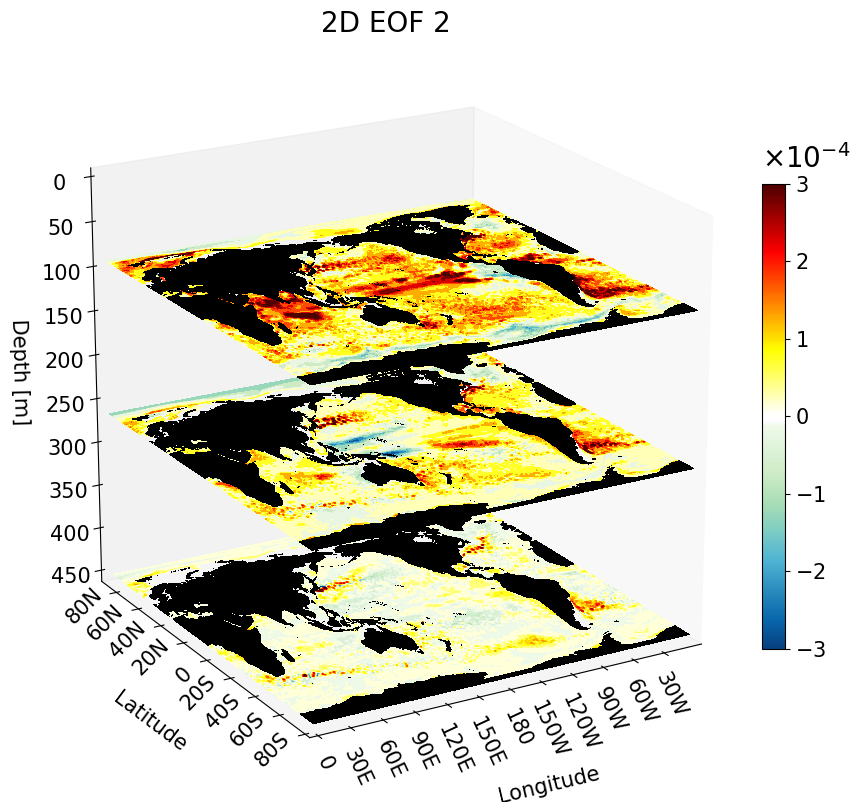

In [251]:

# --- Setup Figure ---
fig = plt.figure(figsize=(10, 16))
title_sz = 20
label_sz = title_sz-5

ax = fig.add_subplot(111, projection='3d')

clip = .0003
vmin, vmax = -clip, clip # Change to scale better
levels = 50


# Contours
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#############################################################################
'''
surface3D = EOF2[0, :,:]
cs2 = ax.contourf(xx[:, :], yy[:, :], surface3D, zdir='z', offset=-depths[0],
                levels=levels, cmap=newcmp2, norm=norm,vmin=vmin, vmax=vmax)

_ = ax.contourf(xx[:, :], yy[:, :], masked_array, zdir='z', offset=-depths[0], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land
'''
#############################################################################
dd = 21
surface3D = EOF2[dd, :,:]
cs2 = ax.contourf(xx[:, :], yy[:, :], surface3D, zdir='z', offset=-depths[dd],
                levels=levels, cmap=newcmp2, norm=norm,vmin=vmin, vmax=vmax)
_ = ax.contourf(xx[:, :], yy[:, :], masked_array, zdir='z', offset=-depths[dd], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land

#############################################################################
dd = 27
surface3D = EOF2[dd, :,:]
cs2 = ax.contourf(xx[:, :], yy[:, :], surface3D, zdir='z', offset=-depths[dd],
                levels=levels, cmap=newcmp2, norm=norm,vmin=vmin, vmax=vmax)
_ = ax.contourf(xx[:, :], yy[:, :], masked_array, zdir='z', offset=-depths[dd], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land
#############################################################################
dd = 30
surface3D = EOF2[dd, :,:]
cs2 = ax.contourf(xx[:, :], yy[:, :], surface3D, zdir='z', offset=-depths[dd],
                levels=levels, cmap=newcmp2, norm=norm,vmin=vmin, vmax=vmax)
_ = ax.contourf(xx[:, :], yy[:, :], masked_array, zdir='z', offset=-depths[dd], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land
#############################################################################
#############################################################################
ax.grid(False)
ax.set_xticks(lon_ticks, labels=[format_longitude(int(l)) for l in lon_ticks], fontsize=label_sz, rotation = -65) # Requires format_longitude function to remove degree symbol
ax.set_yticks(lat_ticks, labels=[format_latitude(int(l)) for l in lat_ticks], fontsize=label_sz, rotation = 45, ha = 'right', va = 'center')  # Requires format_latitude function to remove degree symbol
ax.set_zticks(-depth_ticks, labels=[f"{t:.0f}" for t in depth_ticks], fontsize=label_sz)
ax.tick_params(axis='x', pad=0, labelsize=label_sz)
ax.tick_params(axis='y', pad=0,  labelsize=label_sz)
ax.tick_params(axis='z', pad=7,  labelsize=label_sz)
ax.set_xlabel('Longitude', fontsize=label_sz, labelpad=25)
ax.set_ylabel('Latitude', fontsize=label_sz, labelpad=16)
ax.set_zlabel('Depth [m]', fontsize=label_sz, labelpad=16, rotation=0)
ax.set_title("2D EOF 2", fontsize=title_sz)

ax.set_xlim(lon[0], lon[-1])
ax.set_ylim(lat[0], lat[-1])
ax.set_zlim(-depths[depth_cut_end], 0)


ax.set_box_aspect((1, 1, 1))
# view from above to make sure plot matches
ax.view_init(elev=20, azim=-120, vertical_axis='z')
#############################################################################
# the colorbar for the EOF data
sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax,format = mpl.ticker.ScalarFormatter(useMathText=True), fraction=0.03, pad = 0)
cbar.ax.yaxis.get_offset_text().set_fontsize(title_sz) # change exp size
cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
cbar.update_ticks()

plt.savefig('E:/Paper Figs/3D EOF 2 warming.png', dpi=300, bbox_inches='tight')


In [76]:
EOF2_3D = -read_EOFs(2, os.path.join(data_directory, 'cut_EOFs/Entire Ocean'))


In [291]:
depths[16]

40.34405

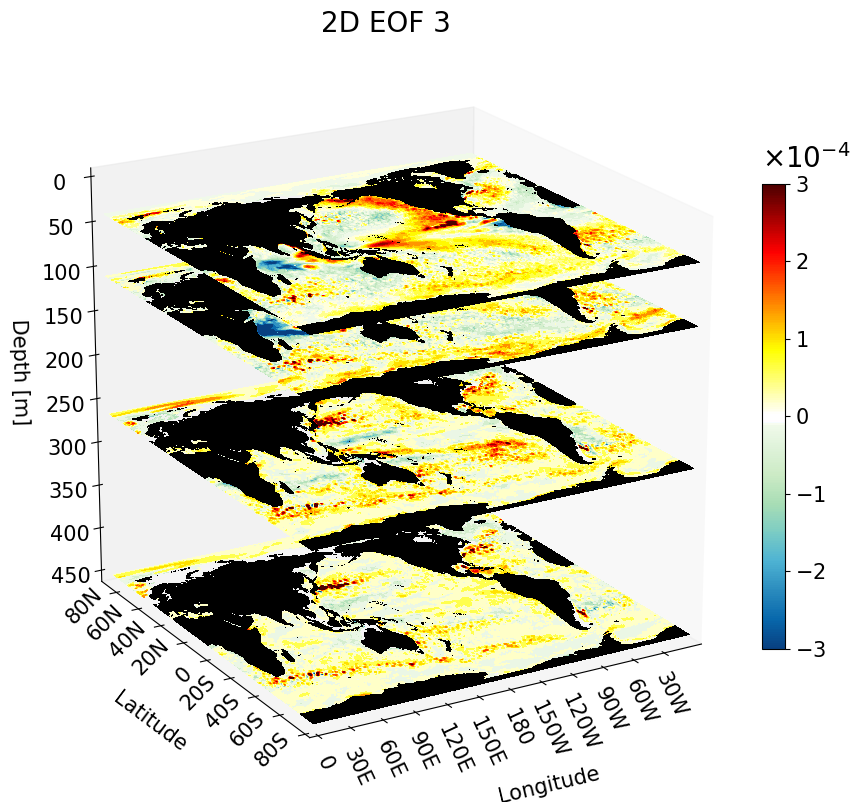

In [297]:
lat_cut_start = 0
lat_cut_end = -1
lon_cut_start =0
lon_cut_end = -1
depth_cut_end = 30

lon_ticks   = np.arange(lon[lon_cut_start], lon[lon_cut_end]+1, 30)
lat_ticks   = np.arange(lat[lat_cut_start], lat[lat_cut_end]+1, 20)
depth_ticks = np.arange(0, depths[depth_cut_end], 50)



# create grid to plot in x and z for the y cross section
xx,yy = np.meshgrid(lon, lat)
# plotting land
mask = np.isnan(EOF2[0, :,:]) # create a mask for the NaN values
masked_array = np.where(mask, EOF2[0, :,:], np.nan)          # change points with values to NaN
end_of_map = np.nanmin(EOF2[31,:,:]) # minimum value to define bottom of map
masked_array = np.where(~mask, masked_array, end_of_map) # change NaN points to values
# --- Setup Figure ---
fig = plt.figure(figsize=(10, 16))
title_sz = 20
label_sz = title_sz-5

ax = fig.add_subplot(111, projection='3d')

clip = .0003
vmin, vmax = -clip, clip # Change to scale better
levels = 50


# Contours
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#############################################################################
'''
surface3D = EOF2[0, :,:]
cs2 = ax.contourf(xx[:, :], yy[:, :], surface3D, zdir='z', offset=-depths[0],
                levels=levels, cmap=newcmp2, norm=norm,vmin=vmin, vmax=vmax)

_ = ax.contourf(xx[:, :], yy[:, :], masked_array, zdir='z', offset=-depths[0], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land
'''
#############################################################################
dd = 0
surface3D = EOF3[dd, :,:]
cs2 = ax.contourf(xx[:, :], yy[:, :], surface3D, zdir='z', offset=-depths[dd],
                levels=levels, cmap=newcmp2, norm=norm,vmin=vmin, vmax=vmax)
_ = ax.contourf(xx[:, :], yy[:, :], masked_array, zdir='z', offset=-depths[dd], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land

#############################################################################
dd = 22
surface3D = EOF3[dd, :,:]
cs2 = ax.contourf(xx[:, :], yy[:, :], surface3D, zdir='z', offset=-depths[dd],
                levels=levels, cmap=newcmp2, norm=norm,vmin=vmin, vmax=vmax)
_ = ax.contourf(xx[:, :], yy[:, :], masked_array, zdir='z', offset=-depths[dd], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land

#############################################################################
dd = 27
surface3D = EOF3[dd, :,:]
cs2 = ax.contourf(xx[:, :], yy[:, :], surface3D, zdir='z', offset=-depths[dd],
                levels=levels, cmap=newcmp2, norm=norm,vmin=vmin, vmax=vmax)
_ = ax.contourf(xx[:, :], yy[:, :], masked_array, zdir='z', offset=-depths[dd], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land
#############################################################################
dd = 30
surface3D = EOF3[dd, :,:]
cs2 = ax.contourf(xx[:, :], yy[:, :], surface3D, zdir='z', offset=-depths[dd],
                levels=levels, cmap=newcmp2, norm=norm,vmin=vmin, vmax=vmax)
_ = ax.contourf(xx[:, :], yy[:, :], masked_array, zdir='z', offset=-depths[dd], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land
#############################################################################
#############################################################################
ax.grid(False)
ax.set_xticks(lon_ticks, labels=[format_longitude(int(l)) for l in lon_ticks], fontsize=label_sz, rotation = -65) # Requires format_longitude function to remove degree symbol
ax.set_yticks(lat_ticks, labels=[format_latitude(int(l)) for l in lat_ticks], fontsize=label_sz, rotation = 45, ha = 'right', va = 'center')  # Requires format_latitude function to remove degree symbol
ax.set_zticks(-depth_ticks, labels=[f"{t:.0f}" for t in depth_ticks], fontsize=label_sz)
ax.tick_params(axis='x', pad=0, labelsize=label_sz)
ax.tick_params(axis='y', pad=0,  labelsize=label_sz)
ax.tick_params(axis='z', pad=7,  labelsize=label_sz)
ax.set_xlabel('Longitude', fontsize=label_sz, labelpad=25)
ax.set_ylabel('Latitude', fontsize=label_sz, labelpad=16)
ax.set_zlabel('Depth [m]', fontsize=label_sz, labelpad=16, rotation=0)
ax.set_title("2D EOF 3", fontsize=title_sz)

ax.set_xlim(lon[0], lon[-1])
ax.set_ylim(lat[0], lat[-1])
ax.set_zlim(-depths[depth_cut_end], 0)


ax.set_box_aspect((1, 1, 1))
# view from above to make sure plot matches
ax.view_init(elev=20, azim=-120, vertical_axis='z')
#############################################################################
# the colorbar for the EOF data
sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax,format = mpl.ticker.ScalarFormatter(useMathText=True), fraction=0.03, pad = 0)
cbar.ax.yaxis.get_offset_text().set_fontsize(title_sz) # change exp size
cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
cbar.update_ticks()

plt.savefig('E:/Paper Figs/3D EOF 3 mix 2.png', dpi=300, bbox_inches='tight')


In [249]:
import string
labels = [f'({letter})' for letter in string.ascii_lowercase[:14]]

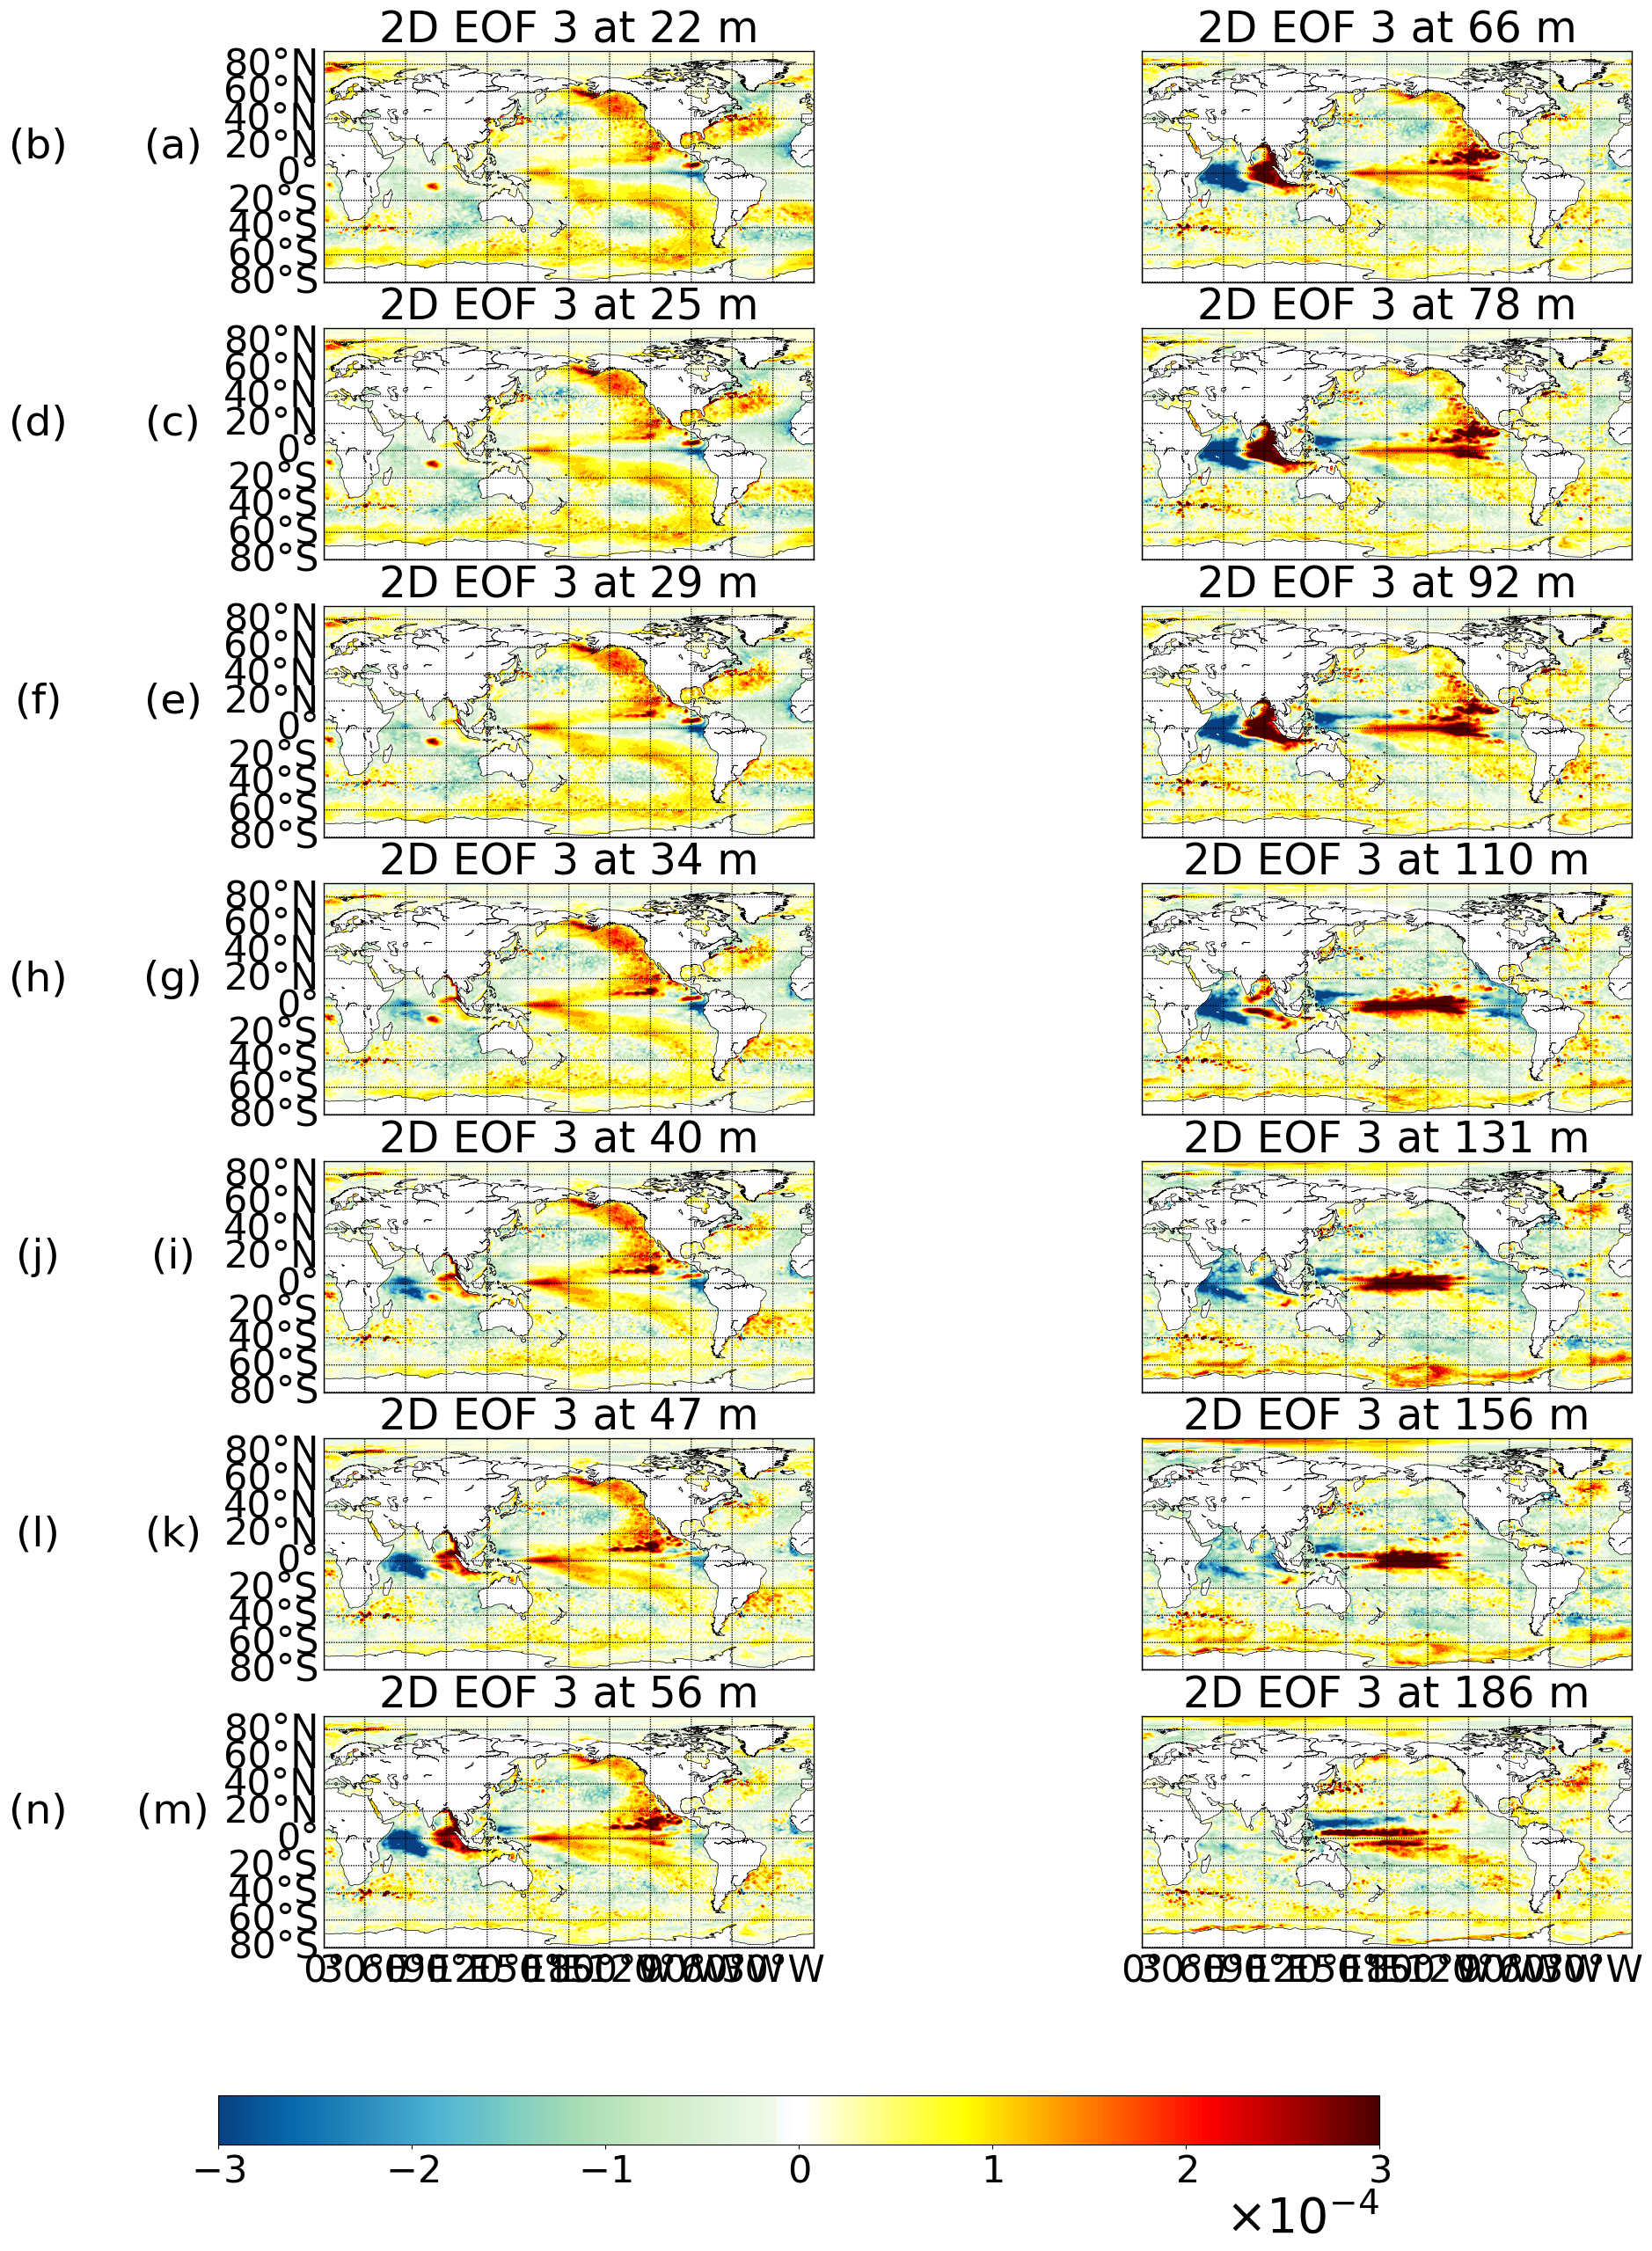

In [283]:
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#fig = plt.figure(figsize=(19, 36.))
fig = plt.figure(figsize=(20, 32))

title_sz = 35
label_sz = title_sz - 4
tick_sz = 5

clip = .0003
# Create a GridSpec layout with different widths for the first and second columns
gs = GridSpec(7, 2)  # Adjust the first subplot width with a larger ratio

ind = np.where(p3_value3<.05)[0]

###################################################################
# Second subplot with standard width
for i in range (7):
    
    ax = fig.add_subplot(gs[i, 0])
    if i == 0:
        plt.ylabel(labels[i], rotation='horizontal', size=title_sz-1, labelpad=120)
    else:
        plt.ylabel(labels[2*i], rotation='horizontal', size=title_sz-1, labelpad=120)
    
    depth_ind = ind[i]
    
    dat = EOF3[depth_ind, :, :]
    dat = np.maximum(np.minimum(dat, clip), -clip)
    
    mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                    llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
    mymap.drawcoastlines(color='black', linewidth=.5)
    mymap.drawmapboundary()
    mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
    if i == 6:
        mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz, rotation = 45)
    else:
        mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)
    
    norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
    ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)
    
    plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)
###################################################################
# Second subplot with standard width
for i in range(7):   
    ax = fig.add_subplot(gs[i, 1])
    plt.ylabel(labels[2*i+1], rotation='horizontal', size=title_sz-1, labelpad=30)
    depth_ind = ind[7+i]
    
    dat = EOF3[depth_ind, :, :]
    dat = np.maximum(np.minimum(dat, clip), -clip)
    
    mymap = Basemap(projection='cyl', llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                    llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1], resolution='c')
    mymap.drawcoastlines(color='black', linewidth=.5)
    mymap.drawmapboundary()
    mymap.drawparallels(np.arange(cut_lat[0], cut_lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
    if i == 6:
        mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz, rotation = 45)
    else:
        mymap.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)
    
    
    norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
    ax.contourf(cut_lon, cut_lat, dat, 20, cmap=newcmp2, norm = norm)
    
    plt.title(f"2D EOF 3 at {round(depths[depth_ind])} m", size=title_sz)


###################################################################
# Colorbar settings remain unchanged
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
cax = fig.add_axes([0.15, 0.03, 0.65, 0.02]) #(left, bottom, width, height)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])
cbar = plt.colorbar(sm, cax = cax, orientation='horizontal', format = mpl.ticker.ScalarFormatter(useMathText=True))
cbar.ax.xaxis.get_offset_text().set_fontsize(title_sz+5)
cbar.ax.yaxis.OFFSETTEXTPAD = title_sz
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
plt.savefig('E:/Paper Figs/2D EOFs 22 to 186.png', dpi=300, bbox_inches='tight')
plt.show()
